## Final Project Submission
**Student name:** David Boyd

**Student pace:** Self paced

**Scheduled project review date/time:** 9/05/2023 21:00 UK time

**Instructor name:** Abhineet

## Business Objective

We want to build a model that helps to identify via tweets whether there was a positive, negative or neutral sentiment  in the messsage, either towards a brand or a product/app. The dataset we are using focuses on 9000 different tweets that happened during SXSW event and has four different options of sentiment these are:
- Positive
- Negative
- Neutral/neither positive nor negative
- I can't tell

## Data Understanding

The dataset comes from CrowdFlower via data.worldLinks. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither, which can be found in tweets_dataset.csv in the data folder in this repository. The dataset includes 9,092 entries, and 3 columns. Here are the columns in the dataset including our target variable, sentiment

- `tweet_text` - The column contains the contents of the tweet that was captured
- `emotion_in_tweet_is_directed_at` - This column identifies whether the tweet was targeted to a brand or a specific product. There are a lot of NULL values in this column, so it's not super helpful initially
- `is_there_an_emotion_directed_at_a_brand_or_product` - This column helps to identify the sentiment of the tweet

## Importing packages & EDA

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, plot_confusion_matrix
from sklearn import metrics

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davidboyd/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidboyd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
## Reading in the data into a dataframe and viewing the top 5 records for inspection
df = pd.read_csv('Data/tweets_dataset.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
list = ['emotion_in_tweet_is_directed_at','is_there_an_emotion_directed_at_a_brand_or_product']

## Helping to identify what are all the categories that are listed inside each of the columns that isn't the tweet text itself
for item in list:
    print(f'The column name is {item}')
    print(df[item].unique())
    print(df[item].value_counts())

The column name is emotion_in_tweet_is_directed_at
['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64
The column name is is_there_an_emotion_directed_at_a_brand_or_product
['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, 

In [8]:
## Removing the records which have an unknown sentiment option - Keeping the options to just Positive, Negative & Neutral
df = df[~df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['I can\'t tell'])]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8936 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8937 non-null   object
dtypes: object(3)
memory usage: 279.3+ KB


In [9]:
tweet_df = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']].copy()

## Renaming columns to make easier to read
tweet_df.columns = ['tweet_text', 'sentiment_classification']

tweet_df.head()

,tweet_text,sentiment_classification
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [10]:
## Helping to encode the labels and store them in a dictionary for future lookup process
tweet_df['category_id'] = tweet_df['sentiment_classification'].factorize()[0]
category_id_df = tweet_df[['sentiment_classification', 'category_id']].drop_duplicates()


In [11]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'sentiment_classification']].values)

tweet_df.head()


,tweet_text,sentiment_classification,category_id
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,1


In [12]:
id_to_category

{0: 'Negative emotion',
 1: 'Positive emotion',
 2: 'No emotion toward brand or product'}

In [13]:
## dropping all null value columns
tweet_df.dropna()

,tweet_text,sentiment_classification,category_id
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,1
...,...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion,1
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product,2
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product,2
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product,2


In [14]:
## Converting the tweet text into str format, otherwise the tokenising of the text doesn't work later on
tweet_df['tweet_text'].dropna(inplace=True)
tweet_df['tweet_text'] = tweet_df['tweet_text'].astype(str)

In [15]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweet_text                8937 non-null   object
 1   sentiment_classification  8937 non-null   object
 2   category_id               8937 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 279.3+ KB


## EDA - Understanding which terms has highest correlation with each category

In [16]:
tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each tweet into a vector
features = tf_idf.fit_transform(tweet_df.tweet_text.values.astype('U')).toarray()


labels = tweet_df.category_id

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 8937 tweets is represented by 4603 features (TF-IDF score of unigrams and bigrams)


In [17]:
# Finding the five most correlated terms with each of the product categories
N = 5
for sentiment_classification, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tf_idf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(sentiment_classification))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))



==> Negative emotion:
  * Most Correlated Unigrams are: classiest, fail, headaches, hate, fascist
  * Most Correlated Bigrams are: design headaches, news apps, fascist company, ipad news, company america

==> No emotion toward brand or product:
  * Most Correlated Unigrams are: begins, app, awesome, wins, cool
  * Most Correlated Bigrams are: comes cool, quot apple, begins apple, wins sxsw, apple wins

==> Positive emotion:
  * Most Correlated Unigrams are: comes, begins, awesome, wins, cool
  * Most Correlated Bigrams are: comes cool, apple comes, begins apple, wins sxsw, apple wins


## Baseline Model

In [18]:
X = tweet_df['tweet_text'].astype(str)
y = tweet_df['category_id']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42, stratify=y)

### Tf-Idf and count Vectorisation

In [24]:
# creating a count 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(tweet_df['tweet_text'].values.astype('U'))

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(X_train.values.astype('U'))
xtest_count =  count_vect.transform(X_test.values.astype('U'))


In [25]:
# word-level tf-idf
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=4000)
tfidf.fit(tweet_df['tweet_text'].values.astype('U'))
xtrain_tfidf =  tfidf.transform(X_train.values.astype('U'))
xtest_tfidf =  tfidf.transform(X_test.values.astype('U'))

# ngram (uni, bi)-level tf-idf
tfidf_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range = (2,3) , max_features=4000)
tfidf_ngram.fit(tweet_df['tweet_text'].values.astype('U'))
xtrain_tfidf_ngram =  tfidf_ngram.transform(X_train.values.astype('U'))
xtest_tfidf_ngram =  tfidf_ngram.transform(X_test.values.astype('U'))

In [26]:
def train_model(classifier, train_df, label, test_df):
    
    # fit the training dataset on the classifier
    classifier.fit(train_df, label)
    
    # predict the labels on test dataset
    predictions = classifier.predict(test_df)
    
    return metrics.accuracy_score(predictions, y_test)

In [27]:
# Naive Bayes on Count Vectors
accuracy = train_model(MultinomialNB(), xtrain_count, y_train, xtest_count)
print("NB, Count Vectors: ", accuracy)

NB, Count Vectors:  0.7013422818791947


In [28]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

NB, WordLevel TF-IDF:  0.6817673378076062


In [29]:
# Naive Bayes on n-gram Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("NB, n-gram TF-IDF: ", accuracy)

NB, n-gram TF-IDF:  0.6940715883668904


## Text Pre-Processing

In order to improve performance we want to complete the following steps to help reduce/remove the noise from the messy text data. These steps are:
- **Step 1:** Tokenize all tweets
- **Step 2:** Lower case  all tokens
- **Step 3:** Remove all punctuation
- **Step 4:** Remove @mentions
- **Step 5:** html.unescape(text) to remove HTML parsing
- **Step 6:** Remove urls
- **Step 7:** Remove all non asci characters
- **Step 8:** Split attached words
- **Step 9:** Remove common words related to the event itself such as **sxsw**
- **Step 10:** Standardise words (if they use too many letters)
- **Step 11:** Stem/lemmatise words

This will then allow us to fit out models with a cleaner, hopefully more robust dataset.


In [59]:
def get_wordnet_pos(tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [60]:
sw = stopwords.words('english')
additional_sw = ['sxsw', 'link', 'quot', 'lt', 'amp', 'gt', 'mention']

sw.extend(additional_sw)

In [61]:
def tweet_preprocessor(tweet, stop_words=sw):
    '''
    Takes in a raw formatted tweet from the dataset
    
    Returns: A tweet which has:
        - Removed stopwords
        - Removed URLs
        - Removed @mentions
        - Removed HTML tags
        - Removed SXSW string
        - Removed all characters which aren't letters or numbers
        - Lower cased all words
        - Split up any attached words
        - Standardised any words
        - Lemmatised words
    '''
      
    regex_token = RegexpTokenizer(r"([a-zA-Z0-9]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    print(tweet)
    return ' '.join(tweet)


In [62]:
token_tweets = [tweet_preprocessor(tweet, sw) for tweet in X_train]

['sxswi', 'hold', 'secret', 'show', 'ft', 'mister', 'heavenly', 'michael', 'cera', '5', 'free', 'beer', '4', 'location']
['nadya', 'direkova', 'riff', 'sid', 'meier', 'user', 'engagement', 'w', 'game', 'mechanic', 'reward', 'user', 'first', '10', 'minute']
['conf', 'everyone', 'mac', 'ipad', 'include', 'happen', 'pc', 'become', 'obsolete']
['heard', 'apple', 'go', 'open', 'special', 'store', 'expecting', 'lot', 'customer']
['hear', 'ex', 'apple', 'ex', 'pentagram', 'industrial', 'designer', 'really', 'cool', 'perspective', 'gsdm']
['like', 'vega', 'ce', 'iphone', 'best', 'use', 'hand', 'warmer']
['compete', 'circle', 'socialflow', 'board', 'resonant', 'topic']
['devops', 'provider', 'cloudkick', 'monitor', 'pagerduty', 'page', 'dnsmadeeasy', 'postmark', 'ec2', 'azure', 'google']
['official', 'app', 'go', 'android', 'iphone', 'ipad']
['try', 'make', 'detailed', 'colour', 'cod', 'google', 'calendar', 'prove', 'really', 'tough', 'also', 'get', 'organize']
['new', 'ubersocial', 'iphone', '

['rt', 'note', 'self', 'downside', 'tweet', 'white', 'ipad', '2', 'expect', 'mock']
['mayer', 'google', 'hire', '6', '000', 'people', 'year', 'response', 'audience', 'question', 'hire', 'jr']
['rt', 'medium', 'circus', 'guy', 'walk', 'apple', 'popup', 'store', '1st', 'ipad2']
['say', 'ipad', 'photo', 'apple', 'store']
['rt', 'google', 'tv', 'v', '2', 'late', 'overrun', 'xbox', 'ps3', 'wii', 'netflix', 'like', 'ready', 'barry', 'diller', 'qa']
['frankenstein', 'amalgamation', 'fragment', 'digital', 'identity', 'become', 'anti', 'schizophrenic', 'google', 'ai', 'sm', 'sci', 'fi']
['enchantment', 'like', 'say', 'please', 'register', 'go', 'google', 'hahah']
['rt', 'get', 'soundcloud', 'iphone', 'app', 'start', 'record', 'use', '4sq', 'geotagging', 'map']
['rt', 'party', 'podcasts', 'designerdrugs', 'iampaintedface', 'h0u5t0n']
['tweet', 'session', 'go', 'first', 'young', 'entrepreneur', 'marissa', 'mayer', 'google', 'wordpress']
['yayrt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'in

['wait', 'anymore', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'via', 'google', 'circle']
['anyone', 'picture', 'apple', 'pop', 'store', 'austin', 'wanna', 'see']
['get', 'look', 'rumor', 'apple', 'pop', 'store', 'austin', 'via']
['sort', 'wish', 'pop', 'apple', 'store', 'sell', 'actual', 'apple', 'joke']
['rt', 'awesome', 'free', 'iphone', 'app', 'keep', 'track', 'friend', 'meet', 'find', 'people']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle']
['austinites', 'check', 'iphone']
['play', 'around', 'iphone', 'app', 'awesome', 'use', 'lot']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'update', 'happen']
['list', 'google', 'leh', 'event', 'go', 'upset', 'already', 'cr48']
['rt', 'apple', 'set', 'open', 'popup', 'shop', 'core', 'action']
['pop', 'apple', 'store', 'apple', 'store', 'w', '86', 'others', 'pic']
['founder', 'confirm', 'new', 'iphone', 'summer']
['dont',

['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'via', 'mentionw']
['one', 'must', 'apps', 'survive', 'join', 'sxswbarcrawl', 'sxswi']
['rt', 'pepsicostage', 'yesterday', 'check', 'bag', 'may', 'ipad', 'screen', 'tell', 'mine']
['yup', 'rt', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['group', 'chat', 'apps', 'tell', 'l', 'two', 'apps', 'yet', 'avail', 'android', 'point', 'need', 'phone', 'apps']
['wait', 'eagerly', 'google', 'launch', 'secret', 'new', 'social', 'network', 'call', 'circle', 'today', 'new', 'update']
['people', 'line', 'team', 'android', 'award']
['rt', 'fun', 'google', 'pic']
['apple', 'open', 'temporary', 'store', 'austin', 'ipad', '2', 'launch']
['glad', 'hear', 'chance', 'create', 'iphone', 'case', 'u', 'yet', 'let', 'make', 'happen', 'zazzlesxsw']
['rt', 'google', 'circle', 'take', 'facebook', 'circle']
['dislike', 'people', 'constantly', 'look', 'iphone', 'ipad', '

['ideally', 'google', 'logos', 'bring', 'people', 'together', 'socially', 'creative', 'lead', 'google', 'doodle', 'team', 'gsdm', 'googledoodle']
['check', 'mistake', 'make', 'build', 'netflix', 'iphone', 'go', 'cool', 'always', 'learn', 'mistake']
['oooh', 'want', 'rt', 'recap', 'recycle', 'skateboard', 'iphone', 'case']
['social', 'calendar', 'app', 'roll', 'special', 'functionality', 'iphone', 'android']
['thanks', 'everyone', 'come', 'today', 'good', 'luck', 'win', 'ipad', 'stop', 'tomorrow', 'chance', 'win']
['rt', '2011', 'novelty', 'ipad', 'news', 'apps', 'fade', 'fast', 'among', 'digital', 'delegate']
['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'cont']
['add', 'schedule', 'android', 'go', 'app', 'handy']
['hey', 'great', 'sf', 'coffee', 'nice', 'meet']
['gowalla', 'founder', 'start', 'sketch', 'passport', 'stamp', 'would', 'look', 'like', 'newly', 'release', 'iphone']
['desktop', 'publishing', 'save', 'apple', 'pagemaker', 'gift', 'god']
['rt',

['chris', 'poole', '4chan', 'recommend', 'google', 'refrigerator', 'magnet', 'game', 'cute', 'share', 'experience', 'game', 'sxswmoot', 'sxswi']
['ipad', '2', 'good', 'time', 'improve']
['win', 'free', 'ipad', '2', 'webdoc', 'com', 'rt']
['check', 'poke', 'liked', 'tweeted', 'google', 'love', 'story', 'sxsw15', 'sxswic']
['rt', 'group', 'challenge', 'come', 'iphone', 'app', 'solve', 'parent', 'start', 'issue']
['rt', 'apple', 'take', 'old', 'ipads', 'teach', 'america', 'user', 'get', 'tax', 'write', 'buy', 'new', 'ipad', 'kinda', 'cool']
['download', 'free', 'sampler', 'band', 'play']
['u', 'read', 'article', 'google', 'say', 'rumor', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle']
['watch']
['rt', 'rt', 'next', 'life', 'come', 'back', 'ipad', '2', 'woman', 'keep', 'hand', 'thing']
['hootsuite', 'hootsuite', 'mobile', 'update', 'iphone', 'blackberry', 'android', 'whether', 'get', 'friend']
['day', 'bank', 'america', 'launch', 'iphone', 'app', 'get', '250k', 'new', 'cus

['thanks', 'sign', 'ipad']
['funny', 'moment', 'panel', 'dennis', 'crowley', 'get', 'ipad', '2', 'owner', 'hold', 'new', 'ipad', '2', 'look', 'like', 'lighter', 'rock', 'concert']
['tr', 'wonder', 'many', 'come', 'back', 'ipad', '2', 'maybe', 'everyone']
['tech', 'bro', 'pose', 'homeless', 'person', 'outside', 'apple', 'pop', 'sign', 'ask', 'ipad']
['love', 'google', 'street', 'map', 'get', 'idea', 'everything', 'relation', 'austin', 'convention', 'center', 'alamo', 'drafthouse', 'cinema']
['true', 'story', 'rt', 'rat', 'amy', 'ice', 'cream', '5', 'star', 'best', 'ice', 'cream', 'town']
['rt', 'feel', 'like', 'iphone', 'always', 'always', 'something', 'run', 'battery', 'fast']
['example', 'microformat', 'recipe', 'finder', 'google', 'week', 'ago', 'google', 'adapt', 'microformats', 'microformats']
['rt', 'quote', 'day', 'ipad', 'interface', 'design', 'relatable', 'discoverable', 'ipad', 'digital']
['rt', 'download', '20', 'free', 'track', 'music', 'sampler', 'available', 'store', 'toda

['look', 'best', 'iphone', 'app', 'hail', 'cab', 'austin', 'free', 'possible', 'austin', 'iphoneapp']
['hmm', 'break', 'google', 'circle', 'story', 'morning', 'point', 'u', 'article', 'scinfluence']
['last', 'month', 'discovr', 'ipad', 'midem', 'time', 'discovr', 'iphone', 'climb', 'app', 'store', 'chart']
['hang', 'hilton', 'lobby', 'downtown', 'austin', 'stop', 'say', 'hi', 'check', 'android', 'controller', 'sonos']
['rt', 'follow', 'leanux', 'panel', 'realtime', 'google', 'doc', 'thanks']
['cool', 'team', 'startup', 'come', 'via', 'siliconvalley', 'bus', 'hack', 'apps', 'ex', 'google', 'au', 'stage', 'w', 'speakermeetup', 'dogpatch', 'lab']
['rumour', 'location', 'apple', 'pop', 'store', 'iun', 'austin', 'texas', 'cheer']
['pack', 'need', 'geek', 'batman', 'like', 'utility', 'belt', 'gadget', 'iphone', 'ipad', 'mba', 'apple', 'tv', 'overdrive', 'hotspot', 'headphone', 'etc']
['rt', 'apple', 'hp', 'pop', 'set', 'temp', 'site', 'austin', 'atx', 'austinbusiness']
['cnnmoney', '2011', '

['social', 'important', 'google', 'screw', 'big', 'launch', 'circus', 'socialmedia']
['two', 'guy', 'google', 'doodle', 'team', 'talk', 'fun', 'making', 'homepage', 'pretty']
['rt', 'simple', 'gesture', 'ipad', 'use', 'core', 'interaction', 'touchingstories']
['ipad', '2', 'good', 'product', 'time', 'make', 'worthwhile', 'improvement', 'diller']
['omgz', 'makeshift', 'apple', 'store', 'gold', 'gym']
['right', 'wow', 'rt', 'wiebe', 'walk', 'conceptual', 'graphing', 'loving']
['rt', 'apple', 'two', 'austin', 'area', 'retail', 'location', 'anticipation', 'gadget', 'ipad', 'gadget']
['rt', 'hey', 'austin', 'know', 'little', 'iphone', 'android', 'love', 'music', 'wanna', 'make', '20', 'hour', 'please', 'let', 'know']
['get', 'iphone', 'android', 'app', 'im', 'back', 'phone', 'gap', 'session', 'show', 'app', 'get', 'window', 'phone', 'marketplace', 'free']
['ipad', 'go', 'sale', 'friday', 'day', 'start', 'wonder', 'many', 'attendee', 'spend', 'friday', 'standing', 'line', 'gsdm']
['design', 

['know', 'u', 'u', 'selling', 'weve', 'never', 'talk', 'hate', 'product', 'rt', 'check', 'heyo', '4', 'iphone', 'sxswi']
['video', 'playbook', 'action', 'ipad', 'still', 'win']
['best', 'mobile', 'app', 'android', 'app', 'make', 'panel', 'party', 'agenda', 'offline', 'use', 'get']
['ipad', '2', 'take', 'video']
['near', 'field', 'communication', 'already', 'android', 'phone', 'bemyneighbor']
['great', 'talk', 'game', 'mechanic', 'u', 'cant', 'make', 'good', 'make', 'red', 'u', 'cant', 'make', 'red', 'make', 'big']
['get', 'food', 'forget', 'snap', 'photo', 'win', 'macbook', 'air', 'ipad', '2', 'apple', 'tv']
['web', 'designer', 'guide', 'io', 'android', 'apps', 'today', '10']
['google', 'presentation', 'trade', 'show', 'busy', 'trade', 'show', 'nice', 'side', 'time']
['google', 'look', 'social', 'signal', 'search', 'result', 'qagb']
['look', 'like', 'google', 'publicly', 'deny', 'circle', 'present', 'today']
['guy', 'like', 'presentation', 'wanna', 'try', 'filmaster', 'iphone']
['rt', 

['2wks', 'apple', 'store', '6th', 'austin', 'street', 'open']
['rt', 'agree', 'novelty', 'ipad', 'news', 'apps', 'fade', 'fast', 'among', 'digital', 'delegate', 'medium', 'via']
['take', '8th', 'row', 'plane', 'spot', 'ipad', 'think', 'go', 'elonsxsw']
['rt', 'google', 'launch', 'new', 'social', 'network', 'circle', 'possibly', 'today']
['pick', 'mophie', 'battery', 'case', '4', 'iphone', 'prep', 'lug', 'around', 'laptop', 'use', 'phone', 'huge', 'win', 'last', 'year']
['awesome', 'ipad', 'sxswbuffalo', 'lounge', 'experience', 'complete']
['marissa', 'mayer', '150', 'user', 'google', 'map', 'mobile', '1st', 'time', 'ever', 'app', 'born', 'web', 'use', 'mobile', 'app']
['check', 'trade', 'show', 'right', 'across', 'google']
['google', 'crisis', 'response', 'site', 'w', 'good', 'info', 'japanese', 'earthquake', 'tsunami', 'sxswi']
['sweet', 'danfung', 'dennis', 'demo', 'immersive', 'video', 'rig', 'ipad', 'platform', 'use', 'hell', 'back', 'party']
['free', 'cd', 'download', 'various', '

['rt', 'check', 'mom', 'ipad', 'design', 'boomer']
['rt', 'secret', 'search', 'sauce', 'google', 'bing', 'spill', 'bean', 'google', 'bing']
['rt', 'fantasy', 'bracket', 'challenge', 'ipad', '2', 'giveaway', 'via', 'constantcontact', 'marchmadness', 'selectionsunday']
['live', 'tweeting', 'panel', 'google', 'marissa', 'mayer', 'present', 'start', '3', '30', 'follow', 'along', 'use', 'suxsw', 'hashtag']
['guy', 'buy', 'first', 'ipad2', 'popup', 'store', 'hope', 'register', 'thoora', 'beta']
['holy', 'smoke', 'ipad2', 'replace', 'flip', 'cam', 'default', 'video', 'capture', 'device', 'beautiful', 'elegant', 'apple']
['fun', 'google', 'analytics', 'berklee', 'topspin', 'class', 'use', 'great', 'info', 'marketing', 'music']
['one', 'lone', 'dude', 'await', 'ipad', '2', 'apple', 'store', 'apple', 'likely', 'expect', 'big', 'crowd']
['saw', 'google', 'speak', 'create', 'search', 'engine', 'tht', 'recognize', 'picture', 'artificial', 'intelligence']
['ironic', 'google', 'direction', 'party', '

['rt', 'apparently', 'google', 'ad', 'preference', 'see', 'google', 'think', 'like', 'seenocreepy', 'pnid']
['40', 'google', 'map', 'usage', 'mobile', 'wow', 'via']
['ugh', 'think', 'effectively', 'break', 'party', 'google', 'calendar', 'much', 'go', 'psychedthough']
['meant', 'itunes', 'work', 'ie', 'run', 'apple', 'software', 'even', 'would', 'run', 'ubuntu', 'desktop', 'dl']
['knew', 'localmind', 'hit', 'get', 'huge', 'press', 'review', 'earlier', 'localmind']
['rt', 'woot', 'google', 'lego', 'hackathon', 'competition', 'startupbus', 'cle']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'via', 'cc', 'mentionc']
['easy', 'review', 'small', 'business', 'drive', 'google', 'place', 'seo', 'smm']
['rt', 'rt', 'flipboard', 'develop', 'iphone', 'version', 'android', 'say', 'sxswi']
['new', 'ubersocial', '4', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponsor', 'mashable']
['diabetes', 'plate', 'thanks', 'google', 'already', 'cover']
['fret', 'iphone', '

['rt', 'hmm', 'com', 'interactive', 'live', 'stream', 'ipad', 'mobile', 'compatible', 'maybe', 'next', 'year']
['tech', 'lightbox', 'photo', 'want', 'new', 'android', 'camera', 'app', 'technology']
['rt', 'drive', 'around', 'austin', 'google', 'street', 'view', 'scoping', 'location', 'desk']
['totally', 'love', 'copia', 'cocoon', 'messenger', 'ipad', 'bag', 'pick', 'attend', 'redbox', 'gilt', 'group', 'graphic', 'ly', 'sesh', 'morning']
['unofficial', 'app', 'showcase', 'mobile', 'iphone']
['rt', 'excellent', 'presentation', 'digital', 'magazine', 'touchingstories']
['rt', 'interest', 'google', 'mobile', 'stats', '40', 'google', 'map', 'user', '150', 'million', 'come', 'mobile']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle']
['google', 'doodle', 'kind', 'social', 'agenda', 'remind', 'u', 'facts', 'event', 'belong', 'u', 'googledoodle']
['rt', 'google', '80', 'party', 'maggie', 'mae', 'w', '64', 'others']
['foursquare', 'see', 'google', 'competition', 'locat

['love', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['flight', 'sf', 'austin', 'fill', 'google', 'tshirts', 'youtube', 'fleece']
['rt', 'diller', 'would', 'product', 'ipad', 'one', 'form', 'factor', 'today', 'multichannel', 'multi', 'platform', 'world', 'ketchsx']
['win', 'free', 'music', 'sampler', 'itunes', '22', 'track', 'industry', 'favorites', 'breakout', 'artist']
['google', 'circle', 'real', 'fake', 'contradict', 'blog', 'post', 'statement', 'chris', 'messina', 'via']
['rockin', 'party', 'lake', '1986', 'party', 'google', 'aclu', 'maggie', 'mae']
['dont', 'bite', 'ear', 'rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['hello', 'holler', 'gram', 'get', 'know', 'new', 'ipad', 'app', 'hollergram']
['really', 'need', 'another', 'big', 'social', 'network', 'right', 'thanks', 'google']
['10', 'minute', 'line', 'ipad', '2', 'temporary', 'apple', 'store']
['amen', 'google', 'tweet', 'new', 'think', 'sp

['google', 'year', 'ai', 'ask', 'u', 'want', 'know', 'smscifi']
['rt', 'panel', 'mom', 'ipad', 'design', 'boomer']
['rt', 'head', '1pm', 'cst', 'today', 'win', 'vip', 'access', 'acoustic', 'solo', 'set', 'tonight', 'alguien', 'ahi']
['beware', 'android', 'app', 'schedule', 'completely', 'innacurate', 'walked', 'hyatt', 'reason', 'sxswfail']
['honestly', 'think', 'everyone', 'own', 'laptop', 'truestory']
['cross', 'finger', 'today', 'seem', 'hopeful', 'apple', 'store', 'w', '23', 'others']
['release', 'today', 'spin', 'play', 'spin', 'magazine', 'ipad', 'app', 'download', '1st', 'issue', 'free']
['race', 'ballroom', 'see', 'marissa', 'mayer', 'sxswi']
['stop', 'quick', 'iphone', 'charge', 'macallan']
['guess', 'crowd', 'line', 'ab', 'ipad', 'mashhash', 'party']
['great', 'news', 'u', 'twit', 'crew', 'apple', 'building', 'temporary', 'store', '2011', 'u', 'get', 'ur', 'ipad', '2']
['lose', 'hour', 'tonight', 'attendee', 'blame', 'microsoft', 'apple', 'get', 'credit', 'fix', 'christmas']


['rt', 'room', 'full', 'people', 'w', 'good', 'wi', 'fi', 'run', 'frostwire', 'android', 'share', 'pic', 'apps', 'vids', 'w', 'others']
['sxswnui', 'apple', 'define', 'language', 'touch', 'different', 'dialect', 'become', 'small']
['z43', 'let', 'body', 'hit', 'floor', 'code', 'valid', '8', '00', '11', '59', '59a', '03', '15', '11', 'infektd', 'zlf']
['marissameyer', 'google', 'go', 'able', 'get', 'content', 'back', 'sure', 'heard', 'right']
['head', 'shortly', 'record', 'video', 'popup', 'apple', 'store', 'southby', 'expect', 'big', 'ipad2', 'sale']
['amuse', 'apple', 'pop', 'store', 'year', 'brilliant', 'idea', 'brilliant']
['check', 'iphone', 'app', 'nice', 'check', 'fun']
['ipad', '2', 'sell', 'temporary', 'apple', 'store', 'congress']
['get', 'folk', 'prettycool', 'chevysxsw', 'rt', 'update', 'iphone', 'retrollect', 'user', 'available', 'awesome']
['among', 'thing', 'miss', 'google', 'aclu', '80', 'dance', 'party']
['adobe', 'develop', 'engine', 'essentially', 'convert', 'swf', 'f

['rt', 'go', 'join', 'google', 'youtube', 'special', 'event', 'google']
['rt', 'get', 'exciting', 'thing', 'show', 'year', 'include', 'drag', 'drop', 'store', 'management', 'iphone']
['new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'conference', 'cc', 'sxswi']
['haha', 'google', 'serve', 'pie', 'booth', '3', '14', '1', '59', 'pm']
['meet', 'three', 'girl', 'apple', 'itunes', 'connect', 'team', 'iphone', 'developer', 'meetup', 'get', '2', 'talk', 'would', 'change', 'itc']
['false', 'alarm', 'google', 'circle', 'come', 'probably', 'ever', 'google', 'circle', 'social']
['totally', 'agree', 'check', 'googletv', 'ipad', 'apps', 'connect', 'tv', 'connectedtv', 'fascinating']
['google', 'preview', 'major', 'new', 'social', 'service', 'circle', 'today', 'say', 'ht']
['blogging', 'iphone', 'check', 'taste', 'whirlwind', 'travel', 'springbreak', 'continue', 'notenoughplaid']
['rt', 'google', 'future', 'power', 'pair', 'augmented', 'reality', 'contextual', 'reality', 'pn

['surprise', 'customer', 'wait', 'line', 'apple', 'store', 'austin', 'ipad', '2', 'cbatsxsw']
['rt', 'oh', 'like', 'believe', 'three', 'boyfriend', 'since', 'first', 'ipad']
['false', 'alarm', 'google', 'circle', 'come', 'probably', 'ever', 'much', 'report', 'would', 'unveil']
['nice', 'see', 'speaker', 'sneak', 'irrelevant', 'snarky', 'comment', 'apple', 'class', 'authenticationdesign']
['ipad2', 'delivery', 'pop', 'store', 'quite', 'possible', 'sxswi']
['5', 'straight', 'day', 'ipad', 'welcome', 'change', 'flip', 'fashion', 'mag', 'printisnotdead', 'digitalblasphemy']
['rt', 'best', 'thing', 'heard', 'weekend', 'give', 'ipad', '2', 'money', 'japan', 'relief', 'need', 'ipad', '2']
['full', 'house', 'apparently', 'people', 'care', 'google', 'ranking', 'synthetic', 'life', 'tsk', 'tsk', 'people', 'qagb']
['rt', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'circle']
['helpful', 'hint', 'charge', 'iphone', 'ipad', 'charger', 'charge', '3', '4', 'time']

['make', 'press', 'room', 'get', 'swag', 'register', 'ipad', '2', 'hopefully', 'get', 'meet', 'mike', 'tyson']
['heard', 'ipads', 'sell', 'except', 'apple', 'pop', 'store', 'true']
['oh', 'snap', '80', 'party', 'host', 'google']
['casually', 'mention', 'forecast', 'dow', 'six', 'day', 'ahead', 'base', 'google', 'mood', 'analysis', 'twitter', 'data', 'smvis', 'imrich']
['funny', 'think', 'see', 'everywhere', 'rt', 'look', 'beard', 'guy', 'plaid', 'iphone', 'nfusion']
['120', 'line', 'temp', '5000', 'sq', 'ft', 'apple', 'store', 'new', 'ipad', 'austin']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'circle']
['rt', 'look', 'blue', 'hair', 'get', 'free', 'android', 'phone', 'info', 'sticker', 'allhat3']
['wanna', '5', '6', 'chinese', 'dude', 'bff', 'bring', 'effen', 'iphone', 'charger']
['use', 'glass', 'lie', 'lie', 'phone', 'face', 'people', 'handsfree', 'connection', 'think', 'apple', 'arsxsw']
['rt', 'news', 'ipad', 'go', 'enterprise'

['rt', 'haha', 'awesomely', 'rad', 'ipad', 'app', 'hollergram', 'via']
['rt', 'ipad', '2', 'take', 'video', 'apple', 'ipad']
['break', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'today', 'via', 'socialmedia']
['iphone', 'app', 'control', 'mania', 'half', 'screen', 'use', 'button', 'filter', 'half', 'content', 'ui', 'fail']
['heard', 'rumor', 'google', 'circle', 'suppose', 'preview']
['rt', 'even', 'begin', 'apple', 'win', 'gonna', 'get', 'sum', 'via']
['google', 'quash', 'circle', 'rumour', 'rt', 'launching', 'product', 'plenty', 'else']
['rt', 'join', 'start', 'tonight', 'person', 'friend', 'city', 'end', 'festival', 'win', 'ipad', '2']
['rt', '40', 'google', 'map', 'use', 'mobile']
['rt', 'nieuwe', 'regel', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', '911tweets', 'panel']
['rt', 'right', 'rain', 'edchat', 'musedchat', 'sxswi', 'classical', 'newtwitter']
['google', 'vp', 'speak', 'topic', '10', 'quick', 'step', 'own', 'everything', '

['apple', 'open', 'temporary', 'store', 'conference', 'ipad', '2', 'launch', 'might', 'make', 'stop']
['get', 'back', 'door', 'invite', 'google', 'party', 'goona', 'network', 'as']
['help', 'win', 'ipad', '2', 'click', 'like', 'follow', 'picture', 'party', 'thanks']
['look', 'forward', 'learn', 'ipad', 'design']
['anyone', 'know', 'hour', 'apple', 'store', 'kinda', 'hop', 'open', '24', 'hour']
['google', 'art', 'project', 'would', 'great', 'virtual', 'field', 'trip', 'kid', 'museums', 'around', 'world', 'edtech']
['ask', 'favorite', 'non', 'google', 'product', 'say', 'swiss', 'watch']
['ready', 'mingle', 'fellow', 'sxsurrogates', 'gsdm', 'gsd', 'google', 'present', 'industry', 'party']
['rt', 'wake', 'sandwich', 'iphone', 'ipad', 'forget', 'much', 'like', 'geek', 'spring', 'break']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'update', 'preview', 'plan']
['rt', 'anyone', 'know', 'apple', 'store', 'still', 'ipads']
['league', 'extraordinary', 'hacker', 'ev

['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app']
['two', 'day', 'last', '6', 'month', 'mobile', 'usage', 'google', 'map', 'higher', 'desktop', 'marissa', 'mayer']
['interest', 'rt', 'apple', 'open', 'pop', 'shop', 'sxswi', 'popupshop', 'apple']
['know', 'time', 'iphone', 'blackberry', 'camera', 'hotel', 'clock', 'tv', 'say', 'different', 'time', 'austin', 'texas', 'time']
['know', 'go', 'austin', 'tomorrow', 'iphone', 'definitely', 'try', 'convince', 'go', 'autism']
['every', 'game', 'app', 'ad', 'interactive', 'guide', 'show', 'either', 'iphone', 'ipad', 'two', 'promos', 'show', 'wp7', 'android']
['privacy', 'could', 'headline', 'google', 'circle', 'social', 'network', 'reveal', 'later', 'today', 'social', 'network', 'aclu', 'googlecircles']
['anyone', 'news', 'ipad', '2', 'must', 'course']
['hate', 'ipad', 'fleet', 'nerd', 'arm', 'ipads', 'navigate', 'crowd', 'far', 'cool', 'ever', 'see']
['z17', 'protect', 'innocent', 'en6p2e', 'code', 'valid', '8', '00', '11', '59', 

['google', 'circle', 'invite', 'follow', 'interested', 'google', 'circle']
['rt', 'ipad', 'store', 'sell', 'everything', 'except', '64gig', 'wifi', 'white']
['google', 'launch', 'social', 'network', 'circle', 'excite']
['new', 'competition', 'q2', 'google', 'check', 'offer', 'smccolumbus']
['rt', 'marc', 'ecko', 'launch', 'iphone', 'app', 'autodial', 'political', 'change', 'edreform', 'edtech', 'eduvc', 'fightthepaddle']
['apple', 'popup', 'store']
['lose', 'way', 'care', 'much', 'business', 'tim', 'reilly']
['help', 'advance', 'getoutthevote', 'ipad', 'iphone', 'startup', 'cbus', 'cbustech']
['gd', 'idea', 'rt', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', '911tweets', 'panel']
['rt', 'ipad', '2', 'take', 'video']
['among', 'company', 'try', 'make', 'impression', 'interactive', 'sxswi']
['probably', 'right', 'time', 'surely', 'way', 'rt', 'venturebeat', 'get', 'social', 'texas', 'google', 'tech']
['post', 'facebook', 'deal', 'beluga', 'get', 'final', 'tune', 'tc', '

['rt', 'play', 'fave', 'new', 'iphone', 'app', 'wow', 'rock', 'next', 'week']
['learn', 'ab', 'google', 'doodle', 'doodle', 'light', 'funny', 'innovative', 'exception', 'significant', 'occasion', 'googledoodle']
['press', 'coverage', 'life', 'stand', 'apple', 'line']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle']
['facebook', 'killer', 'google', 'circle', 'announce', 'interactive', 'festival', 'google']
['put', 'pop', 'apple', 'store', 'smart', 'talk', 'understand', 'demo', 'need']
['apple', 'store', 'pop', 'huge', 'crowd', 'wait', 'geek', 'dream', 'come', 'true']
['hear', 'apple', 'open', 'temporary', 'store', 'via']
['rt', 'one', 'minute', 'ago', 'guy', 'speak', 'outside', 'apple', 'pop', 'austin', 'store', 'would', 'get', 'hand', 'ipad', '2', 'wait', 'since', '6', '30am']
['google', 'social', 'medium', 'rt', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news']
['jealous', 'love', 'apple', 'store']
['hire', 'marketer', 'designer', 'crea

['rt', 'wow', 'thing', 'insanely', 'thin', 'light', 'hold', 'ipad', '2', 'seriously', 'mosaicxm']
['two', 'ipad', 'observation', 'vast', 'majority', 'people', 'use', 'see', 'lot', '2', 'today', 'look', 'nice', 'appletakingoverworld']
['rt', 'able', 'afford', 'attend', 'buy', 'ipad', 'today', 'consider', 'save', 'japan', 'earthquake', 'relief']
['wanna', 'know', 'rt', 'one', 'producer', 'go', 'hopefully', 'free', 'iphone', 'apps', 'dl']
['talk', 'local', 'search', 'surprise', 'google', 'hotpot', 'weight', 'review', 'heavy', 'site', 'result', 'cc']
['rt', 'head', 'austin', 'austin', 'guide', 'iphone', 'free', 'limited', 'time', 'lp', 'travel']
['anyone', 'know', 'apple', 'store', 'sell', 'macbook', 'battery', 'sxswi']
['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponsor', 'mashable']
['begin', 'story', 'cool', 'app', 'also', 'apple', 'launch', 'ipad', '2', 'temp', 'store', 'stay', 'tune', 'love']
['set', 'ipad2', 'swift', 'upbeat', 'service', 'morning', 

['rt', 'facebook', 'killer', 'google', 'circle', 'announce', 'interactive', 'festival', 'google']
['explain', 'use', 'chartbeat', 'google', 'analytics', 'mitharvard']
['new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponsor', 'mashable']
['cool', 'rt', 'coolest', 'ipad', 'case', 'ever', 'etch', 'sketch', 'via']
['marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'world', 'mobile']
['chance', 'booth', 'sell', 'new', 'ipad', '2']
['new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased']
['yes', 'google', 'party', 'glow', 'cup']
['google', 'hotpot', 'anyone', 'use']
['apple', 'pop', 'store', 'austin', 'take', 'shape', 'week', 'call', 'pop']
['redcross', '90999', 'rt', 'afford', 'attend', 'buy', 'ipad', 'today', 'consider', 'japan', 'earthquake', 'relief']
['rt', 'google', 'launch', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['dangerous', 'ipad', 'life', 'jaqueline', 'bojan']
['leave', 'tradeshow', 'demo', 'googl

['google', 'circle', 'come', 'soon', 'new', 'social', 'network', 'photo', 'video', 'status', 'update', 'sxswi']
['fear', 'extend', 'wed', 'rt', 'rt', 'last', 'day', 'apple', 'popup', 'sunday', '3', '13', 'appleatxdt']
['photo', 'spending', 'sit', 'night', 'chat', 'husband', 'skype', 'iphone', 'coffee']
['best', 'schwag', 'see', 'battery', 'charger', 'iphone', 'get', 'one']
['anonymity', 'zuckerberg', 'wrong', 'say', '4chan', 'moot']
['quadroid', 'qualcomm', 'android', 'call', 'platform', 'next', 'decade', 'v', 'wintel', 'cloud']
['crowdbeacon', 'put', 'together', 'guide', 'late', 'update', 'iphone', 'app', 'go', 'sick']
['apple', 'seem', 'win', 'app', 'world']
['rt', 'mashable', 'weekend', 'recap', '19', 'story', 'may', 'miss', 'twitter', 'android']
['oh', 'apple', 'ridiculous', 'even', 'begin', 'apple', 'win', 'via']
['us', 'google', 'tv', 'room', 'nobody', 'raise', 'hand', 'pack', 'room', 'socialviewing', 'session']
['rt', 'aron', 'pilhofer', 'new', 'york', 'time', 'endorsed', 'html'

['rt', 'get', 'free', 'coverage', 'app', 'know', 'austin', 'get', 'best', 'cellular', 'data', 'connection']
['spot', 'man', 'need', 'ipad', '2', 'sxswi']
['rt', 'oh', 'god', 'rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['rt', 'apple', 'set', 'open', 'popup', 'shop', 'austin', '6th', 'con', 'via', 'sxswprsa', 'prsa']
['rt', 'ipad2', 'unbox', 'outside', 'apple', 'store']
['google', 'marissa', 'meyers', 'product', 'feature', 'agree']
['rt', 'get', 'look', 'rumor', 'apple', 'pop', 'store', 'austin', 'via']
['strange', 'think', 'last', 'year', 'ipad', 'ie9', 'preview', 'release']
['google', 'calendar', 'get', 'little', 'control']
['reason', 'apple', 'continue', 'survival', 'existence', 'god', 'enchantment', 'sxswi']
['google', 'know', 'everything', 'map', 'people', 'traffic', 'around', 'world', 'sxtxstate']
['web', 'page', 'appear', 'google', 'qagb']
['fsw', 'want', 'know', 'spec', 'parse', 'ajax', 'link']
['rt', 'head', 'pvhouse', 'firs

['sweet', 'rt', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', '911tweets', 'panel']
['watch', 'marissa', 'mayer', 'talk', 'advance', 'future', 'google', 'location', 'base', 'augmented', 'reality', 'project', 'cool', 'sxswi']
['rt', 'see', 'best', 'ipad', 'case', 'ever', 'start', 'transfer', 'bit', 'book', 'fetishism', 'ipads', 'slowly', 'surely']
['500', 'e', 'cesar', 'chavez', 'st', 'austin', 'texas']
['soundtrckr', 'feature', 'must']
['receive', 'lot', 'message', 'tell', 'sexy', 'response', 'post', 'look', 'meet', 'fellow', 'christian', 'iphone', 'devs']
['rt', 'social', 'technology', 'amaze', 'google', 'set', 'person', 'finder', 'english', 'japanese']
['find', 'app', 'kyping', 'iphone', 'geolocation', 'release', 'background', 'need', 'patch', 'batterykiller']
['rad', 'rt', 'hey', 'dude', 'give', 'away', 'sampler', 'band', 'w', 'free', 'glasser', 'track', 'pick']
['rt', 'look', 'fwd', 'ipad'

['rt', 'want', 'free', 'juice', 'pack', 'air', 'iphone', '4', 'give', 'away', '5', 'announce', 'location', 'stay', 'tune']
['rt', 'seenatsxsw2011', 'best', 'thing', 'see', 'far', 'man', 'beg', 'street', 'corner', 'money', 'ipad', '2', 'front', 'apple', 'store', 'sad']
['google', 'possibly', 'launch', 'social', 'medium', 'service']
['face', 'ipad', '2', 'background', 'image']
['die', 'antwoord', 'awesome', 'umshini', 'wam', 'korine', 'park', 'night', 'fish', 'amaze', 'especially', 'shot', 'iphone', '4']
['would', 'love', 'chk', 'ie9', 'handset', '1', 'thats', 'upcoming', 'seduce', 'away']
['quote', 'day', 'ipad', 'interface', 'design', 'relatable', 'discoverable', 'ipad', 'digital']
['rt', 'crash', 'segway', 'google', 'technology']
['blogger', 'due', 'update', 'google', 'finally', 'take', 'action', 'showcase', 'new', 'design']
['rumour', 'around', 'google', 'circle', 'proven', 'untrue', 'announcement', 'austin', 'texas', 'must', 'something']
['hop', 'easy', 'get', 'ipad', '2', 'today', 

['kawasaki', 'pagemaker', 'save', 'apple', 'oh', 'day', 'jwtatl', 'enchantment', 'via']
['download', 'torrent', 'need', 'put', 'iphone']
['like', 'say', 'peep', 'take', 'picture', 'ipad', '2', 'look', 'ridculous', 'still', 'want', 'one']
['apple', 'plan', 'keep', 'austin', 'wire', 'open', 'pop', 'apple', 'store']
['even', 'begin', 'apple', 'win', 'apple', 'ipad2', 'tc']
['android', 'app', 'know', 'battery', 'killer']
['rt', 'ipad', '2', 'sell', '70', '1st', 'time', 'user']
['apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch', 'cc']
['google', 'rumor', 'unveil', 'new', 'social', 'network', 'circle', 'today']
['rt', 'bound', 'keep', 'eye', 'may', 'give', 'away', 'iphone', 'case', 'atx', 'land']
['well', 'ipad', 'commercial', 'want', 'minimize', 'wear', 'tear', 'laptop']
['z28', 'curfew', 'damn', 'code', 'valid', '8', '00', '11', '59', '59p', '03', '13', '11', 'infektd', 'zlf']
['forget', 'disneyland', 'apple', 'pop', 'store', 'austin', 'happy', 'place', 'ea

['rt', 'apple', 'build', 'pop', 'store', '3', 'day', 'open', '24', '7', 'selling', 'ipad', '2']
['wooooo', 'apple', 'store', 'downtown', 'austin', 'open', 'til', 'midnight']
['photo', 'make', 'austin', 'make', 'make', 'party', 'host', 'google', 'aclu']
['inside', 'ipad', '2', 'chip', 'bring', '50', 'browsing', 'boost', 'rt', 'best', 'hungry', 'tip', 'mekong', 'river', 'g']
['sit', 'ground', 'wait', 'ipad', 'austin', 'apple', 'popup', 'store', 'geek']
['rt', 'google', 'map', 'route', 'around', 'traffic', 'save', 'user', '2', 'year', 'every', 'day', 'marissa', 'mayer']
['apple', 'open', 'temporary', 'store']
['hear', 'google', 'may', 'launch', 'social', 'network', 'event', 'tonight']
['overload', 'info', 'deliver', 'google', 'kill', 'discovery', 'google', 'say', 'ppl', 'lose', 'curiosity', 'wonder', 'need', 'serendipity']
['guy', 'couch', 'play', 'white', 'ipad', '2', 'mashbash', 'party', 'around', 'make', 'statement', 'dammit']
['ux', 'ipad', 'uxdes', 'remember', 'ultimately', 'aware', 

['excite', 'wait', 'rt', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['user', 'drive', '12b', 'mile', 'year', 'google', 'map', 'navigation', 'jr']
['socialmuse', 'android', 'available', 'genius', 'lookalike', 'music', 'listening', 'appcircus']
['1', 'hour', 'ago', 'apple', 'store', 'downtown', 'austin', 'store', 'hundred', 'people', 'ipad2']
['apple', 'cocky', 'perhaps', 'separate', 'ipad2', 'store', 'would', 'good', 'idea', 'guess', 'need', 'extra', 'marketing']
['come', 'google', 'party', 'gsd', 'badge', 'get', 'u', 'free', 'food', 'drink', 'music', 'big', 'place', 'line', 'great', 'party', 'come']
['review', 'probably', 'download', 'torrent', 'make', 'thing', 'slow']
['cruisin', 'austin', 'check', 'venue', 'tomorrow', 'night', 'saw', 'looong', 'apple', 'ipad', 'line']
['either', 'go', 'wait', 'line', 'buy', 'trick', 'ipad', 'mom', 'birthday', 'guess', 'austin']
['temp', 'apple', 'store']
['mr', 'google', 'recommend', 'submit', 'article', 'bank

['rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'l']
['rt', 'p', 'google', 'throw', 'b', 'tchin', 'party', 'shout', 'spazmatics']
['cute', 'rt', 'one', 'fav', 'photo', 'far', 'google']
['surprise', 'consumerization', 'make', 'way', 'conversation', 'cloud', 'adoption', 'apple', 'ui', 'influence', 'enterprise', 'cloud']
['rt', 'marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'world', 'mobile']
['line', 'popup', 'apple', 'store', '6th', 'congress', 'still', 'block', 'long']
['rt', 'stumble', 'around', 'lose', 'stay', 'contact', 'group', 'iphone', 'app', 'idealab', 'il']
['rt', 'get', 'crave', 'mind', 'create', 'app', 'foodspotting', 'iphone', 'apps']
['yeah', 'sure', 'rt', 'check', 'google']
['new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'conference', 'augcomm', 'hcsm', 'mhealth']
['get', 'view', 'master', 'last', 'night', 'wait', 'see', 'discs', 'popular', 'win', 'ipad', '2']
['rt', 'say', 'ipad', 'photo

['register', 'private', 'beta', 'win', 'apple', 'tv', 'visit', 'detail']
['google', 'launch', 'social', 'network', 'google', 'circle']
['day', 'later', 'still', 'line', 'door', 'apple', 'store', 'ipad2']
['approach', 'soft', 'launch', 'plan', 'android', 'demo', 'run', 'flyer', 'print', 'shirt', 'pack', 'austin']
['wave', 'buzz', 'rt', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'circle']
['netflix', 'iphone', 'app', 'build', 'ridiculous', 'deadline', 'big', 'mistake', 'tech', 'part', 'agree']
['last', 'least', 'get', 'copy', 'stupid', 'game', 'plus', 'iphone', 'also', 'special', 'price']
['intend', 'bring', 'trusty', 'backpack', 'upcoming', 'trip', 'number', 'ipad', '2', 'help', 'buy', 'back', 'e', 'posible']
['last', 'session', 'today', 'leave', 'brain', 'search', 'google', 'right', 'brain', 'search', 'x', 'bettersearch']
['apple', 'selfish', 'brand', 'microsoft', 'serve', 'brand', 'well']
['attend', 'report', 'see', 'android', 'phone', 'get', 'ba

['poor', 'austin', 'rt', 'ipad', '2', 'launch', 'coincides', 'fri', 'afternoon', 'apple', 'store', 'employee', 'austin', 'may', 'begin', 'weep']
['steve', 'job', 'position', 'iphone', 'device', 'make', 'china', 'suicide', 'rate', 'high', 'sell', 'dream', 'kawasaki', 'thisisdare']
['launchrock', 'vencorps', 'want', 'give', '30k', 'best', 'startup']
['rt', 'shhhh', 'promo', 'code', 'ipad', '2', 'giveaway', 'sxsw2011', 'web', 'developer', 'win']
['rt', 'google', 'launch', 'check', 'service', 'provide', 'deal', 'fmsignal', 'sxswi']
['gear', 'list', 'music', 'iphone', 'vzw', 'blackberry', 'sprint', 'ipad', 'jambox', 'hp', 'elitebook', 'lack', 'good', 'portable', 'headphone', 'suggestion']
['true', 'rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', '4', 'ipad', '2', 'launch']
['apple', 'pop', 'store', 'tech']
['discovr', 'available', 'iphone', 'kill', 'get']
['google', 'friend', 'salicornia', 'rt', 'name', 'bio', 'diesel', 'plant', 'grow', 'salt', 'water', 'agchat']


['wow', 'gold', 'gym', 'underneath', 'apple', 'store', 'kind', 'nutshell', 'right']
['hootsuite', 'mobile', 'update', 'iphone', 'blackberry', 'android']
['rt', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['record', 'ipad', '2', 'line', 'merely', 'pass', 'make', 'minor', 'round', 'home']
['hello', 'enjoy', 'ride', 'anywhere', 'austin', '10', 'download', 'groundlink', 'app', 'booth', '437']
['text', '24587', 'chance', 'win', 'ipad', 'draw', '3', '17', 'friend', 'must', 'present', 'win', 'see', 'ya']
['grab', 'late']
['rt', 'co', 'founder', 'google', 'teacher', 'academy', 'bring', 'hs', 'student', 'austin', 'show', 'use', 'tech', 'education']
['anyone', 'else', 'iphone', 'get', 'could', 'activate', 'cellular', 'data', 'network', 'error', 'message', 'warn', 'thing', 'come']
['google', 'launch', 'major', 'new', 'social', 'network', 'really', 'dont', 'need', 'another', 'social', 'network']
['apple', 'intel', 'genentech', 'atari', 'cisco', 'something', 

['google', 'bing', 'q', 'panel', 'like', 'world', 'expensive', 'seo', 'consultation']
['covet', 'new', 'ipad']
['apple', 'store', 'sell', 'last', 'ipad']
['apple', 'set', 'anyone', 'get']
['rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['google', 'dev', 'panel', 'indicate', 'android', 'screen', 'reader', 'work', 'widget', 'native', 'ui', 'web', 'view', 'browser']
['talk', 'ipad', 'design', 'great', 'example', 'insight', 'pick', 'copy', 'book']
['surprise', 'apple', 'open', 'pop', 'store', 'austin', 'nerd', 'town', 'get', 'new', 'ipads', 'http']
['false', 'alarm', 'google', 'circle', 'come', 'probably', 'ever', 'sxswi']
['google', 'photo', 'booth', 'six', 'lounge', 'check']
['rt', 'bore', 'keynote', 'use', 'ipad', 'draw', 'picture', 'even', 'good', 'artist', 'sxswi']
['marissa', 'miller', 'google', 'make', 'shout', 'khan', 'academy', 'great', 'thing', 'education', 'fmsignal', 'cc']
['rt', 'pubcamp', 'kirkus', 'download', 'qrank', 'ipad', 'i

['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'te', 'dije', 'wey']
['cnngrill', 'celebrate', 'piday', 'pecan', 'apple', 'strawberry', 'rhubarb', 'pie', 'let', 'circumference', 'begin', 'sxswi']
['funny', 'even', 'cnn', 'say', 'stay', 'clear', 'austin', 'apple', 'store', 'friday', 'ipad', '2', 'launch', 'cuz']
['rt', 'ning', 'mobile', 'roadie', 'thrill', 'offer', 'unofficial', 'insider', 'guide', 'iphone', 'fun', 'austin']
['attention', 'er', 'rumor', 'pop', 'temporary', 'apple', 'store', 'ipad', '2', 'launch', 'need']
['rt', 'data', 'new', 'oil', 'company', 'like', 'google', 'facebook', 'monopoly', 'term', 'service', 'wary']
['cameron', 'sinclair', 'spearhead', 'japan', 'disaster', 'relief', 'via', 'twitter', 'iphone', 'socialmedia', 'philanthropy']
['well', 'forget', 'nfl', 'lockout', 'right', 'gonna', 'focus', 'get', 'shinmy', 'new', 'ipad', '40min', 'apple', 'make', 'happy', 'nfl']
['arrive', 'early', 'get', 'prime', 'seat', 'presen

['1', 'important', 'thing', 'need', 'design', 'ipad', 'gesture', 'ability', 'talk', 'hand', 'listen']
['blogger', 'orange', 'wodpress', 'blue', 'google', 'own', 'market', 'win']
['rt', 'guy', 'couch', 'play', 'white', 'ipad', '2', 'mashbash', 'party', 'around', 'make', 'statement', 'dammit']
['interest', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['pepsi', 'max', 'market', 'street', 'team', 'show', 'popup', 'apple', 'store', 'line', 'hand', 'drink', 'tshirts']
['apparently', 'ipad', 'iphone', 'app', 'block', 'tweet']
['rt', 'ipad', 'design', 'tip', 'look', 'like', 'physical', 'object', 'ppl', 'interact', 'like', 'one', 'tapworthy', 'gsdm']
['rt', 'zazzle', 'officially', 'come', 'grille', 'zazzlsxsw', 'get', 'make', 'iphone', 'case']
['ipad', 'user', 'slower', 'leisurely', 'usage', 'iphone', 'user', 'tapworthy']
['rt', 'pro', 'tip', 'remove', 'access', 'corporate', 'twitter', 'account', 'iphone', '4pm', 'day']
['hollergram', 'ap

['matt', 'cutts', 'google', 'duane', 'forrester', 'bing', 'stop', 'talk', 'original', 'quality', 'content', 'raidsxsw']
['pop', 'apple', 'store', 'come', '6th', 'street', 'south', 'congress', 'atx']
['google', 'view', 'final', 'end', 'rather', 'tool', 'point', 'user', 'source', 'make', 'decision', 'marissagoogle']
['rt', 'agency', 'push', 'google', 'direction', 'never', 'would', 'go', 'otherwise', 'say', 'creative', 'lab', 'strategy', 'dir']
['rt', 'first', 'line', 'morning', 'apple', 'pop', 'store', 'austin', 'catch', 'morning']
['google', 'launch', 'new', 'social', 'network', 'aclu']
['already', 'see', 'ipad', '2', 'place']
['want', 'win', 'ipad', 'get', 'case']
['rt', 'survive', 'live', 'music', 'app', 'iphone', 'android']
['rt', 'presentation', 'demonstrate', 'pause', 'video', 'new', 'video', 'player', 'pick', 'spot', 'ipad', 'app', 'tveverywhere']
['rt', 'hope', 'everyone', 'rsvp', 'temporary', 'downtown', 'austin', 'apple', 'store']
['industry', 'party', 'present', 'gsdm', 'googl

['rt', 'spread', 'word', 'festival', 'explorer', 'app', 'live', 'free']
['simplegeo', 'mobile', 'phone', 'ubiquity', 'create', 'huge', 'sensor', 'network', 'iphone', '6', 'diff', 'sensor', 'bemyneighbor']
['rt', 'wait', 'fiona', 'apple', 'town', 'somebody', 'kidnap', 'put', 'record', 'studio', 'record', 'new', 'album']
['hey', 'austin', 'know', 'little', 'iphone', 'android', 'love', 'music', 'wanna', 'make', '20', 'hour', 'please', 'let', 'know']
['well', 'do', 'see', 'tonight', 'rt', 'w00t', 'write', 'hollergram', 'ipad', 'app']
['new', 'social', 'network', 'may', 'launch', '2day', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['model', 'one', 'rt', 'apple', 'come', 'cool', 'tech', 'one', 'ever', 'hear', 'cuz', 'go', 'conference']
['rt', 'google', 'connect', 'digital', 'physical', 'world', 'mobile']
['really', 'could', 'use', 'one', 'tiny', 'macbook', 'air', 'read', 'apple', 'set', 'temporary', 'store']
['apple', 'school', 'marketing',

['google', 'zeiger', 'physician', 'never', 'report', 'potential', 'ae', 'yet', 'fda', 'relies', 'physicians', 'operate', 'w', 'data', 'health2dev']
['rt', 'line', '100', 'outside', 'apple', 'pop', 'store', 'sixth', 'congress']
['rt', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'smm', 'really', 'google']
['80', 'band', 'google', 'aclu', '1986', 'party', 'rock']
['art', 'advertising', 'statistic', 'say', 'google', 'admob', 'guy', 'ask', 'question', 'sxflip', 'sxswi']
['rt', 'crazy', 'apple', 'temporary', 'austin', 'store', 'post', 'come', 'pic']
['course', 'apple', 'build', 'temp', 'store', 'austin', 'texas', 'understand', 'concept', 'corral', 'cattle', 'pickmeupanipad2']
['rt', 'rt', 'love', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['oh', 'lordy', 'go', 'rt', 'time', 'apple', 'store', 'open', 'pull', 'ipad2', 'trigger']
['google', 'circle', 'loom', 'google', 'nerd', 'get', 'social']
['meet', 'author', 'h

['rt', 'qrafter', 'well', 'pay', 'free', 'qr', 'code', 'apps', 'scan', 'vcards', 'also', 'download', 'qrcode', 'iphone']
['rt', 'come', 'singapore', 'roar', 'party', '512', '6th', 'street', 'sgroars', 'sxswi']
['guy', 'tall', 'tee', 'ipad', 'hoodies', 'hear', 'first']
['okay', 'really', 'yay', 'new', 'foursquare', 'android', 'app', '11', 'kthxbai']
['google', 'give', 'free', 'google', 'lab', 'laptops', 'open', 'source', 'coder', 'r', 'attend', 'meet', 'get', 'cupcake']
['rt', 'rt', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'circle']
['would', 'love', 'meet', 'u', 'rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['atomic', 'tom', 'rock', 'cnn', 'grill', 'party', 'brooklyn', 'google', 'also', 'food', 'drink', 'fantastic', 'sxswi']
['technology', 'apple', 'school', 'marketing', 'expert', 'thousand', 'town', 'demonstrate', 'social', 'tech']
['sweet', 'siren', 'call', 'gsdm', 'google', 'party', 'start', 'do

['new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponsor', 'mashable']
['google', 'planning', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'preview', 'far', 'super', 'positive']
['check', 'google']
['googledoodle', 'google', 'doodle', 'simple', 'surface', 'complex', 'intricate', 'underneath']
['funny', 'hand', 'earplugs', 'google', 'aclu', 'party', 'go', 'announce', 'bad', 'news', 'want', 'tweet']
['pdx', 'tomorrow', 'drop', 'note', 'tmsxsw', 'apple', 'pop', 'retail', 'store', 'epicenter', 'madness']
['context', 'everything', 'hollrback', 'roll', 'android', 'app', 'eve']
['great', 'see', 'bank', 'money', 'startup', 'recognize', 'future', 'relevance', 'corp', 'like', 'apple', 'google', 'bankinnovation']
['rt', 'launching', 'product', 'plenty', 'else', 'join', 'u', '4', 'h4ckers', '80', 'dance', '2day']
['maybe', 'try', 'calculate', 'much', 'money', 'mahalo', 'lose', 'google', 'farmer', 'update']
['also', 'function', 'ipad', 'sure', 'lot', 'ipa

['c34', 'retreat', 'code', 'valid', '12', '00', '3', '59', '59p', '03', '14', '11', 'infektd', 'cvdc']
['watch', 'mike', 'tyson', 'demo', 'new', 'iphone', 'app']
['platform', 'concertgoers', 'launch', 'android', 'app', 'time', 'mashable']
['welcome', 'enjoy', 'ride', 'anywhere', 'austin', '10', 'dwnld', 'groundlink', 'app', 'booth', '437']
['help', 'advance', 'techstars', 'getoutthevote', 'ipad', 'iphone', 'startup']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['rt', 'arduino', 'android', 'flame', 'skull', 'refrigerator', 'speak', 'salon', 'k', '3', '30pm', 'smartthings']
['apple', 'open', 'temporary', 'store', 'sell', 'ipad', '2', 'tnw']
['q', 'google', 'bing', 'website', 'ranking', 'fun']
['apple', 'bring', 'touch', 'ui', 'mass', 'listen', '2', 'microsoft', 'guy', 'talk']
['apple', 'genius', 'pun', 'intend', 'check']
['apple', 'open', 'temporary', 'pop', 'store', 'austin', 'ipad', '2', 'launch']
['spent', '1', '000', 'come', 'alrea

['rt', 'buy', 'ipad2', 'turn', 'ur', 'ipad1', 'apple', 'store', 'wipe', 'clean', 'donates', 'school', 'mrs', 'job', 'idea', 'apple', 'ipad2']
['4sq', 'see', 'facebook', 'google', 'competition', 'via', 'checkins']
['rt', 'see', 'new', 'texas', 'observer', 'ipad', 'app', 'sxswi', '3', '30', 'sheraton']
['score', 'free', 'imo', 'tshirt', 'outside', 'apple', 'store', 'today', '2', '15', 'pm', 'check', 'imo', 'app', 'ipad', '2', 'ipad2']
['austin', 'wk', 'need', 'iphone', 'ipad', 'fix', 'find', 'guy', 'w', 'sign', 'hilton', 'cnr', 'near', 'conventionctr']
['ming', 'ly', 'launch', 'soon', 'celebrate', 'give', 'away', 'apple', 'tv', 'day', 'launch', 'via']
['friend', 'think', 'abandon', 'reality', 'mean', 'communication', 'iphone', 'stop', 'work', 'fail']
['update', 'iphone', 'app', 'song', 'info', 'select', 'stream', 'incl', '24', '7', 'live', 'video', 'streaming', 'time']
['unofficial', 'torrent', 'great', 'way', 'hear', 'expect', 'year']
['monster', 'ipad', 'jobsearch', 'app', 'video', 'vi

['wish', 'boomer', 'stop', 'disable', 'zoom', 'iphone', 'ipad', 'apps', 'yourmom']
['ipad', '2', 'thanks', 'fxsw']
['last', 'day', 'fastcompanygrille', 'come', 'last', 'day', 'iphone', 'makery', 'zazzlesxsw']
['rt', 'awesome', 'new', 'version', 'iphone', 'new', 'web', 'site', 'come', 'want', 'demo', 'meet', 'pls', 'rt']
['hoot', 'rt', 'new', 'blog', 'post', 'hootsuite', 'mobile', 'update', 'iphone', 'b']
['rt', 'geeking', 'youtube', 'apis', 'google', 'teaching', 'theatre']
['apple', 'open', 'temporary', 'store', 'austin', 'people', 'obviously', 'want', 'shell', '1500', 'macbook']
['new', 'blogger', 'blogging', 'blogger', 'google']
['get', 'first', 'panel', 'today', 'line', 'look', 'like', 'apple', 'store']
['google', 'lego', 'team', '4', 'showdown', 'w', '14', 'team', 'developer', 'make', 'bot', 'w', 'mindstorm', '2nite', 'fight', '12am', 'gsdm']
['experiment', 'paper', 'notebook', 'ipad', 'iphone', 'traditional', 'laptop']
['listen', 'get', 'talib', 'kweli', 'via', 'discovr', 'app', '

['cool', 'google', 'basically', 'foing', 'version', 'apple', 'event', 'show', 'ton', 'new', 'product', 'feature']
['take', 'survey', 'iphone', 'starbucks', 'line', 'get', 'free', 'starbucks', 'gift', 'card', 'instant', 'research', 'instant', 'gratification', 'gsdm']
['rt', 'win', 'ipad', 'rt', 'dgtltribe', 'learn', 'native', 'amer', 'tx', 'ballroom', '5', '7', '11', '00am']
['get', 'owle', 'bubo', 'iphone', '20', 'coupon', 'use', 'code', 'sbsw2011', 'sxswfilm', 'sxswi', 'almedia']
['rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'via']
['press', 'lounge', 'someone', 'get', 'tutorial', 'use', 'touchpad', 'apple', 'laptop', 'honest']
['popup', 'store', 'austin', 'sell', 'nothing', 'iphone', 'battery', 'extenders', 'would', 'make', 'much', 'money']
['arrive', 'u', 'wednesday', 'look', 'microsim', 'use', 'data', 'iphone', 'anyone', 'know', 'option']
['smart', 'hollergram', 'ipad', 'app', 'may', 'leave', 'vuvuzela', 'home']
['rt', 'best'

['oh', 'another', 'way', 'talk', 'shit', 'net', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['rackspace', 'startup', 'program', 'cloud', '2', '0', 'ipad', 'app', 'launch', 'seo', 'sem', 'cloudcomputing', 'topnews']
['awkward', 'jc', 'penneys', 'question', 'ask', 'marissa', 'mayer', 'apparently', 'jc', 'penney', 'location', 'rout', 'macys', 'google', 'map']
['medium', 'circus', 'guy', 'walk', 'apple', 'popup', 'store', '1st', 'ipad2', 'austin', '6th', 'congress']
['rt', 'rt', 'google', 'apple', 'ea', 'game', 'zynga', 'facebook', 'microsoft', 'intuit', 'go', 'gaga', 'go', 'game']
['killer', 'shot', 'get', 'last', 'night', 'nokiaconnects', 'concert']
['today', 'day', 'join', 'mobile', 'social', 'ride', 'need', 'app', 'ride']
['new', 'iphone', 'autocorrect', 'already', 'tried', 'change', 'coworkers', 'visigoth', 'go', 'long', 'five', 'day']
['5', 'essential', 'business', 'collaboration', 'apps', 'ipad', 'bpm', 'sxswi']
['may', 'invite', '

['wonder', 'get', 'kick', 'iphone', 'ipod', 'ipad', 'ianything']
['gg', 'new', 'try', 'social', 'rt', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'via']
['email', 'dd', 'google', 'document', 'need', 'english', 'speaking', 'twitter', 'advocate', 'worldwide', 'event']
['iphone', 'one', 'hand', 'caramel', 'macchiato', 'ouch', 'hiss', 'hot', 'apparently', 'two', 'pump', 'lava', 'begin', 'tmsxsw']
['gawk', 'makeshift', 'apple', 'store', 'sxswi', 'apple', 'store', 'photo']
['rt', 'startup', 'give', 'away', 'free', 'hosting', 'fill', 'chance', 'win']
['oh', 'god', 'app', 'ipad', 'pure', 'unadulterated', 'awesome', 'easy', 'browse', 'event', 'ipad', 'website']
['ipad', '2', 'contest', 'join', 'actsofsharing', 'com', 'start', 'get', 'friend', 'connect', 'user', 'friend', 'city', 'end', 'win']
['hope', 'flop', 'akabuzz', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['apple', 'open', 'pop', 'store', 'austin',

['google', 'show', 'super', 'fast', 'google', 'map', 'mobile', '3d', 'rendering']
['need', 'android', 'love', 'volunteer', '10', '45am', '3']
['four', 'hour', 'six', 'half', 'go', 'adventure', 'worth', 'apple']
['let', 'know', 'get', 'apple', 'tv', 'colleague', 'fly', 'vega', 'short', 'trip', 'day']
['awesome', 'ipad', '2', 'jailbreak', 'grateful', 'dead', 'fab5']
['never', 'think', 'sit', 'floor', 'austin', 'convention', 'center', 'best', 'place', 'plug', 'iphone', 'charger']
['great', 'panel', 'w', 'guy', 'fr', 'google', 'hotpot', 'social', 'recs', 'def', 'end', 'recs', 'discotalk', 'sloanxsw']
['think', 'might', 'go', 'weekend', 'without', 'see', 'ipad', 'case', 'twice']
['team', 'android', 'party', 'lustre', 'pearl', 'nice', 'among', 'people']
['82', 'future', 'tablet', 'buyer', 'say', 'choose', 'apple', 'ipad', 'see', 'pop', 'store']
['rt', 'best', 'thing', 'heard', 'weekend', 'give', 'ipad', '2', 'money', 'japan', 'relief', 'need', 'ipad', '2']
['press', 'release', 'ipad', 'apps'

['attend', 'party', 'interested', 'people', 'wiiings']
['rt', 'rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'austin', 'ipad', '2', 'launch']
['announce', 'today', 'longer', 'wine', 'library', 'tv', 'new', 'app', 'iphone', 'daily', 'grape']
['finally', 'picture', 'rt', 'apple', 'open', 'pop', 'shop', 'report']
['apple', 'open', 'ipad2', 'popup', 'shop', 'core', 'action', 'brilliant', 'bring', 'hot', 'shiny', 'new', 'toy', 'peep']
['currently', '150', 'people', 'line', 'pop', 'apple', 'store']
['within', 'hour', 'buy', 'ipad', 'glenda', 'watson', 'hyatt', 'cerebral', 'palsy', 'able', 'communicate', 'stranger', 'public', 'poursite']
['rt', 'innovation', 'banking', 'come', 'mobile', 'innovator', 'apple', 'google', 'verizon', 'bankinnovation']
['lovin', 'digital', 'band', 'sings', 'iphone', 'play', 'guitar', 'app', 'fan', 'record', 'vids', 'ipad2s', 'cnn', 'digital', 'cnngrill', 'sxswi']
['million', 'iphone', 'case', 'trade', 'show', 'double', 'shuffleboard', 'wax', 'sprinkler', 'th

['rt', 'ipad', 'dj', 'need', 'one', '3am', 'tuesday', 'douche', 'bag', 'need', 'apply']
['phone', 'stay', 'charge', 'crappy', 'iphone', 'would', 'never', 'handle', 'rt', 'sleep', 'crazyfest']
['craziness', 'ipad2', 'apple', 'store']
['rt', 'best', 'thing', 'abt', 'great', 'food', 'drink', 'w', 'patio', 'plenty', 'free', 'park', '5', '10', 'min', 'n', 'mess']
['rt', 'epic', 'one', 'guy', 'wait', 'line', 'ipad', '2', 'austin', 'ipad', 'ipad2']
['future', 'local', 'contextual', 'discovery', 'google', 'marissa', 'mayer', 'argue', 'exceptionally', 'valuable', 'type', 'search']
['us', 'google', 'chrome', 'developer', 'tool', 'point', 'javascript', 'console', 'extensive', 'api', 'killerhack']
['hey', 'heard', 'come', 'grille', 'make', 'comic', 'iphone', 'case', 'say']
['need', 'ipad', 'iphone', 'laptop', 'dictaphone', 'vid', 'camera', 'wow', 'love', 'meet', 'real', 'cerebellum', 'charge', 'people']
['first', 'many', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'p

['video', 'interview', 'google', 'deal']
['quantter', 'launch', 'iphone', 'app', 'soon', 'participate', 'launchrock', 'comp']
['rt', 'ipad', 'app', 'get', 'panned', 'design', 'trump', 'content', 'rightfully']
['look', 'forward', 'iphone', 'android', 'design', 'session', 'wait', 'drink', 'give', 'away', 'stuff', 'get', 'pay']
['google', 'circle', 'happen', 'lose']
['twitter', 'iphone', 'app', 'day', 'head', 'want', 'tweet', 'lot', 'help']
['rt', 'google', 'art', 'project', 'would', 'great', 'virtual', 'field', 'trip', 'kid', 'museums', 'around', 'world', 'edtech']
['rt', 'find', 'hot', 'spot', 'w', 'hot', 'spot', 'app', 'wp7', 'iphone']
['google', 'circle', 'social', 'network', 'idea', 'sound', 'like', 'plan']
['apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['right', 'gowalla', '3', 'app', 'android', 'sweeeeet', 'nice', 'job', 'team']
['rt', 'fest', 'tip', 'iphone', 'douche', 'put', 'away', 'phone', 'talk', 'fellow', 'festgoers', 'line', 'etc', 'good'

['shite', 'app', 'rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponso', 'cont']
['rt', 'tonight', 'check', 'kill', 'check', 'gsd', 'google', 'party', 'come', 'say', 'hi', 'sxswi']
['convince', 'upgrade', 'ipad', '2', 'hold', 'one', 'trade', 'show', 'fail', 'willpower', 'check']
['thanks', 'info', 'apple', 'store', 'closing', 'time', 'head', 'finish', 'iron', 'work', 'bbq', 'sxtxstate']
['refresh', 'liveley', 'informative', 'talk', 'game', 'design', 'mechanic', 'sxswi']
['festival', 'time', 'omg', 'scar', 'get', 'netbook', 'firm', 'ipad', 'droid']
['rt', 'rt', 'apple', 'open', 'pop', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['smartypants', 'get', 'ipad', 'couple', 'minute', 'thanks', 'widfy']


In [63]:
y_train.value_counts()

2    4311
1    2382
0     456
Name: category_id, dtype: int64

In [65]:
def train_predict_model(classifier, train_df, label, test_df):
    
    # fit the training dataset on the classifier
    classifier.fit(train_df, label)
    
    # predict the labels on test dataset
    predictions = classifier.predict(test_df)
    
    #plot_confusion_matrix(classifier, test_df, predictions)
    return predictions, classifier.fit(train_df, label)

In [66]:
def prepare_transformed_datasets(model, X_train_df, y_train_df, X_val_df, y_val_df):
    
    X_t_vec = model.fit_transform(X_train_df)
    X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
    X_t_vec.columns = sorted(model.vocabulary_)
    X_t_vec.set_index(y_train_df.index, inplace=True)

    X_val_vec = model.transform(X_val_df)
    X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
    X_val_vec.columns = sorted(model.vocabulary_)
    X_val_vec.set_index(y_val_df.index, inplace=True)
    
    return X_t_vec, X_val_vec

## Binary Classification - Positive & Negative Tweets only

In [70]:
tweet_df_bin = tweet_df[tweet_df['category_id'].isin([0,1])]
X_bin = tweet_df_bin['tweet_text'].astype(str)
y_bin = tweet_df_bin['category_id']

In [72]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size =0.2, random_state=42, stratify=y_bin)

In [73]:
token_tweets = [tweet_preprocessor(tweet, sw) for tweet in X_train_bin]

['someone', 'buy', 'ipad', 'v1', 'wait', 'line', 'get', 'v2', 'tomorrow']
['think', 'eff', 'hubby', 'line', 'ipad', '2', 'someone', 'point', 'towards', 'line', 'wife', 'number', '2', 'sxswi']
['smart', 'company', 'rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch', 'bit', 'ly', 'g03mzb']
['google', 'map', 'mobile', '5', '2', 'look', 'awesome']
['wish', 'excellent', 'day', 'today', 'get', 'ipad', 'envy']
['rt', 'line', 'move', 'fast', 'rt', 'see', 'two', 'impressive', 'line', 'since', 'one', 'apple', 'store', 'party']
['third', 'time', 'charm', 'google', 'launch', 'new', 'social', 'network', 'cnet', 'news']
['ipad', 'app', 'pure', 'gold']
['mt', 'swisher', 'call', 'apple', 'classiest', 'fascist', 'company', 'america', 'sxflip']
['rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'nptech']
['lbs', 'apps', 'iphone', 'think', 'orlando', 'guess', '2', 'check', 'disney', 'v']
['perfect', 'attention', 'detail', 

['ipad', 'download', 'broadfeed', 'app', 'well', 'content', 'delivery']
['anybody', 'get', 'mobile', 'apps', 'work', 'download', 'android', 'iphone', 'blackberry', 'get', 'stick', 'downloading', 'startup']
['great', 'panel', 'w', 'guy', 'fr', 'google', 'hotpot', 'social', 'recs', 'def', 'end', 'recs', 'discotalk', 'sloanxsw']
['apple', 'ipad', 'pop', 'shop']
['rt', '1st', 'stop', 'chaos', 'hunt', 'austin', 'java', 'get', 'spy', 'game', '4', 'chance', '2', 'win', 'ipad']
['thanks', 'girl', 'rt', 'congrats', 'win', 'last', 'ipad', 'case', 'boyfriend', 'aw', 'cbatsxsw']
['hmm', '9', 'right', 'brain', 'mwrc11', 'leave', 'brain', 'rt', '9', '10', 'attendee', 'mac', 'ipad']
['ipad', 'keep', 'awake', 'thank', 'god', 'buy']
['smtravel', 'heard', 'google', 'plan', 'launch', 'socnet', 'may', 'circle', 'learn', 'lot', '5', 'year', 'lots', 'change', 'via']
['dan', 'neumann', 'announce', 'launch', 'organic', 'first', 'consumer', 'face', 'ipad', 'app', 'broadfeed', 'check']
['ipad', '2', 'another', 

['survive', '1', '6', 'gig', 'space', 'leave', 'iphone', 'shall', 'see']
['rumor', 'apple', 'popup', 'store', 'downtown', 'austin', 'ipad', '2', 'launch', 'smart', 'move', '1of', 'many', 'dfcbto']
['leave', 'bag', 'home', 'today', 'travel', 'light', 'ipad', 'hand', 'really', 'need', 'lug', 'around', 'impedimenta']
['cnnmoney', '2011', 'compute', 'device', 'big', 'ipad', 'pas', 'mobile', 'space', 'buzz', 'wssxsw']
['excite', 'marissa', 'mayer', 'google', 'sxtxstate']
['sync', 'ipad2', 'full', 'apple', 'joy']
['rt', 'ipad', '2', 'sell', '70', 'go', 'new', 'buyer', 'report', 'socialmedia', 'tech', 'ipad2', 'medium']
['bit', 'jealous', 'see', 'attendee', 'ipad2', 'ipad', 'seem', 'obsolete']
['google', 'take', 'mantra', 'dont', 'evil', 'heart', 'yet', 'pride', 'product', 'make', 'guilty', '7th', 'deadly', 'sin', 'superbia']
['luckily', 'pop', 'store']
['check', 'smyle', 'android', 'web', 'group', 'chat', 'share', 'location', 'medium', 'whiteboarding', 'thanks', 'app']
['couple', 'new', 'blo

['apple', 'popup', 'store', 'open', 'noon', 'fresh', 'shipment', 'ipad', '2', 'pretty', 'sure', 'go', 'get', 'one', 'finger', 'cross']
['rt', 'apple', 'classiest', 'fascist', 'company', 'america', 'kara', 'swisher']
['ipad', 'calendar', 'frankeninterface', 'design', 'one', 'interface', 'metaphor', 'use', 'another', 'tapworthy']
['need', 'ipad', 'iphone', 'laptop', 'dictaphone', 'vid', 'camera', 'wow', 'love', 'meet', 'real', 'cerebellum', 'charge', 'people']
['google', 'body', 'beta', 'uber', 'health2dev', 'cool']
['know', 'geek', '16162', 'cross', 'road', 'take', 'picture', 'apple', 'pop', 'store']
['whoa', 'line', 'ipad2', '3blks', 'long', 'apple', 'austin']
['app', 'iphone', 'live', 'rsvp', 'event', 'phone', 'check', 'sundayswagger', 'eventbrite', 'com', '3', '20', 'scoremore']
['apple', 'sell', 'ipad', '2', 'california', 'great', 'building', 'cult', 'following']
['hooray', 'rt', 'apple', 'open', 'pop', 'store', 'austin']
['fest', 'tip', 'iphone', 'douche', 'put', 'away', 'phone', '

['love', 'come', 'get', 'login', 'authorization', 'error', 'almost', 'every', 'time', 'open', 'app', 'iphone']
['wow', 'thing', 'insanely', 'thin', 'light', 'hold', 'ipad', '2', 'seriously', 'mosaicxm']
['surround', 'lot', 'ipad', '2', 'box']
['rt', 'strong', 'rumour', 'abt', 'google', 'unveil', 'new', 'social', 'network', 'call', 'circle', 'look', 'interest']
['zomg', 'ipad', '2', 'p', 'rt', 'look', 'everyone', 'zomg', 'get', 'ipad', '2', 'first', 'day']
['6th', 'congress', 'dude', 'creatively', 'save', 'ipad', '2', 'www', 'socialmediabum', 'tumblr', 'com']
['search', 'via', 'twitter', 'work', 'check', 'google', 'real', 'time', 'search', 'least', 'get', 'result']
['steve', 'job', 'position', 'iphone', 'device', 'make', 'china', 'suicide', 'rate', 'high', 'sell', 'dream', 'kawasaki', 'thisisdare']
['photo', 'far', 'best', 'accessory', 'ipad', 'follow', 'closely', 'margarita']
['rt', 'good', 'news', 'austin', 'eats', 'bbq', 'iphone', 'available', 'itunes', 'austin', 'bbq', 'sxswi', 'via

['feel', 'silly', 'cannot', 'figure', 'update', 'mobile', 'app', 'android', 'seem', 'option', 'bottom', 'leave', 'button']
['ask', 'one', 'booth', 'people', 'apple', 'pay', 'every', 'single', 'booth', 'show', 'product', 'ipad2s', 'say', 'idontbelieve']
['marissagoogle', 'google', 'map', 'mobile', 'use', 'vector', 'fast', 'three', 'dimensional']
['apple', 'seem', 'win', 'app', 'world']
['read', 'groupme', 'sound', 'like', 'incredible', 'app', 'available', 'android', 'phone', 'yet']
['else', 'excite', 'possibility', 'google', 'circle', 'anybody', 'austin', 'give', 'u', 'update', 'goog']
['temporary', 'apple', 'store', 'open', '5pm', '6th', 'congress', 'line', 'already', 'grow', 'ipad', 'view', 'io', 'via']
['shoot', 'video', 'ps', 'pic', 'ipad', '2']
['rt', 'great', 'session', 'ipad', 'design', 'good', 'ui', 'insight', 'tapworthy', 'hisxsw']
['even', '10am', 'austin', 'iphone', 'batt', '54', 'shit', 'notevenstartedyet']
['holler', 'gram', 'ipad', 'itunes', 'app', 'store', 'via']
['google

['google', 'party', 'photo', 'booth', 'fun']
['apple', 'autocorrect', 'weird', 'ogilvy', 'autocorrects', 'idiocy', 'ogilvynotes']
['crowd', 'austin', 'swarm', 'ipad', '2', 'launch', 'via', 'sadly', 'one']
['apple', 'hop', 'notice', 'ipad', '2', 'sxswi', 'technology', 'mobile', 'prodmktg']
['apple', 'pop', 'store', 'like', 'girl', 'scout', 'plant', 'next', 'bank', 'atm', 'ca', 'h', 'money', 'thinmints']
['watch', 'ecademy', 'fascinate', 'true', 'map', 'save', 'itme', 'lot']
['stumble', 'around', 'lose', 'stay', 'contact', 'group', 'iphone', 'application']
['technology', 'apple', 'open', 'pop', 'store', 'austin', 'geekfest', 'apple', 'brian', 'lam', 'thousand', 'tech']
['frabjous', 'day', 'callooh', 'callay', 'baaah', 'lewis', 'carroll', 'crowd', 'swarm', 'ipad', '2', 'launch', 'via']
['ipad', '2', 'launch', 'really', 'south', 'austin', 'inde', 'mac', 'ipad']
['thx', 'rt', 'rt', 'bad', 'want', 'go', 'home', 'read', 'google', 'reader', 'feed', 'geek']
['rt', 'haha', 'awesomely', 'rad', 'i

['heck', 'would', 'anyone', 'want', 'mozilla', 'switch', 'crapkit', 'webkit', 'gecko', 'good', 'stupid', 'apple', 'google', 'bandwaggoners']
['sound', 'like', 'buzz', 'rebranded', 'w', 'inner', 'circle', 'rt', 'google', 'launch', 'new', 'social', 'network', 'circle']
['hitlantis', 'ipad', 'cool', 'song', 'explorer', 'app', 'hitlantis', 'com', 'musicviz']
['2', 'year', 'time', 'save', 'every', 'day', 'people', 'qho', 'use', 'google', 'map', 'route', 'around', 'feature']
['new', 'social', 'network', 'google', 'news', 'abuzz', 'launch', 'googlecircles']
['woot', 'rt', 'spill', 'bean', 'next', 'platform', 'flipboard', 'iphone', 'team', 'start', 'work', 'sxflip']
['pop', 'apple', 'store', 'pure', 'genius', 'international', 'crowd', 'stock', 'go', 'home']
['wow', 'witness', 'homeless', 'guy', 'give', 'detailed', 'ipad', '2', 'inventory', 'info', 'passerby', 'austin', 'popup', 'store']
['rediculous', 'overflow', 'line', 'ipad', 'session', 'sxswsmall', 'interesting', 'talk', 'like', 'say', 'mi

['rt', 'apple', 'open', 'pop', 'shop', 'report']
['get', 'ipad', '2', 'courtesy', 'pop', 'store', 'austin', 'yay', 'allow', 'amount', 'available', 'ipads', 'rise']
['futuremf', 'trajan', 'google', 'destroy', 'title', 'tag', 'website', 'seo', 'open', 'graph', 'protocol', 'add', 'clean', 'title', 'tag', 'instead']
['csr', 'report', 'janecek', 'microsoft', 'give', 'charity', 'apple', 'give', 'nothing', 'everyone', 'room', 'iphone', 'drive', 'decision']
['rt', 'new', 'iphone', 'autocorrect', 'already', 'tried', 'change', 'coworkers', 'visigoth', 'go', 'long', 'five', 'day']
['retire', 'wine', 'library', 'tv', 'move', 'onto', 'daily', 'grape', 'get', 'app', 'yr', 'iphone', 'thankyouecon']
['apple', 'temporary', 'austin', 'outlet', 'another', 'example', 'marketing', 'brilliance', 'via']
['apple', 'open', 'temporary', 'store', 'sell', 'ipad', '2', 'tnw']
['rt', 'last', 'month', 'discovr', 'ipad', 'midem', 'time', 'discovr', 'iphone', 'climb', 'app', 'store', 'chart']
['yeay', 'rt', 'new', 'ub

['best', 'session', 'see', 'far', 'morning', 'music', 'ixd', 'design', 'ipad', 'interface', 'win']
['transparency', 'choice', 'control', 'define', 'google', 'product', 'mayer', 'thereby', 'define', 'google', 'brand', 'value']
['great', 'recap', 'google', 'bing', 'q', 'session', 'website', 'rank', 'qagb', 'via', 'cc']
['rt', 'sponsor', 'apple', 'plaid', 'boy', 'attract']
['totally', 'overshadow', 'apple', 'win', 'rt', 'ipad', '2', 'arrives', 'tomorrow', '5', 'p']
['rt', 'smartphone', 'rule', 'definitely', 'iphone', '4', '96', 'apple', 'smartphone', 'eyeball', 'ip4']
['google', 'launch', 'new', 'social', 'network', 'call', 'circle', 'today', 'applause', 'new', 'privacy', 'model', 'attempt']
['even', 'begin', 'apple', 'win', 'via', 'apple']
['lose', 'ipad', 'corrupt', 'iphone', 'crazy', 'hotel', 'good', 'time', 'aus', 'austin', 'bergstrom']
['make', 'decision', 'id', 'like', 'purchase', 'ipad', 'would', 'perfect']
['omg', 'gonna', 'miss', '2', 'panel', 'stand', 'line', '1', 'panel', 'play

['walk', 'pop', 'apple', 'store', 'like', 'walk', 'future', 'ipad', 'type', 'computer']
['rt', 'get', 'hot', 'late', 'version', 'whrrl', 'available', '2day', '4android', 'iphone', 'bb', 'blackberry']
['even', 'begin', 'apple', 'win', 'apple', 'ipad2', 'pm']
['counting', 'day', 'plus', 'strong', 'canadian', 'dollar', 'mean', 'stock', 'apple', 'gear']
['smart', 'hollergram', 'ipad', 'app', 'may', 'leave', 'vuvuzela', 'home']
['interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'circle', 'sound', 'interesting']
['rt', 'google', 'test', '41', 'shade', 'blue', 'color', 'make', 'difference', 'scale', 'nuance', 'really', 'matter']
['rt', 'think', 'eff', 'hubby', 'line', 'ipad', '2', 'someone', 'point', 'towards', 'line', 'wife', 'number', '2', 'sxswi']
['hello', 'holler', 'gram', 'come', 'take', 'look', 'new', 'first', 'ipad', 'app', 'hollergram']
['fully', 'expect', 'ipad', 'sham', '2']
['rt', 'ipad', 'tablet', 'etc', 'aid', 'great', 'adoption', 'mobile', 'devic

['rt', 'hipster', 'w', 'oversized', 'earphone', 'plug', 'new', 'ipad', 'make', 'happy', 'texas', 'loose', 'gun', 'law']
['ungrateful', 'bc', 'much', 'shit', 'play', 'turn', 'shit', 'iphone']
['exclusive', 'apple', 'ipad', '2', 'review', 'still', 'well', 'rest', 'bnet', 'biz', 'ipad2', 'apple', 'ipad']
['freak', 'everyone', 'ipad', 'iphone', '4', 'mac', 'wow']
['hey', 'iphone', 'love', 'turn', 'art', 'iphone', 'case', 'let', 'u', 'know', 'zazzlesxsw']
['surprise', 'customer', 'wait', 'line', 'apple', 'store', 'austin', 'ipad', '2', 'cbatsxsw']
['apple', 'school', 'marketing', 'expert']
['oh', 'yeah', 'saysshewithoutanipad', 'rt', 'flipboard', 'next', 'platform', 'iphone', 'ceo', 'say', 'via']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['rt', 'win', 'ipad', '2', 'come', 'meet', 'aquent', 'talent', 'agent', 'drop', 'name', 'booth', '1413']
['ipad', 'design', 'panel', 'hilton', 'salon', 'j', 'fill', 'quickly', 'surprise', 'tapworthy', '

['tech', 'ipad', '2', 'get', 'temporary', 'apple', 'store']
['interest', 'presentation', 'ipad', 'help', 'disability', 'insightful', 'poursite']
['add', 'apple', 'pop', 'shop', 'list']
['pick', 'white', 'ipad2', 'today', 'apple', 'store']
['great', 'intro', 'saveustechies', 'video', 'surui', 'carbon', 'project', 'google', 'earth', 'engine']
['google', 'party', 'huge', 'antigov', 'lobby', 'initiative', 'invoke', 'privacy', 'puregenius']
['good', 'info', 'rt', 'improve', 'website', 'ranking', 'advice', 'google', 'bing']
['come', 'check', 'ipad', 'app', 'demo', 'arm', 'sxswparty', 'mon', 'sxsw2011']
['google', 'map', 'mobile', 'go', '3d', 'next', 'release', 'look', 'awesome']
['ipad', '2', 'go', 'sale', 'next', 'friday', 'austin', 'apple', 'store', 'go', 'busy']
['genius', 'move', 'apple', 'open', 'temp', 'store', 'downtown', 'austin', 'via', 'ipad2']
['nc', 'buzz', 'ipad2', 'geekdom', 'austin', 'elevate', 'smart', 'apple']
['go', 'alot', 'well', 'u', 'ipad', '5', 'carry', 'around']
['goo

['apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch', 'oh', 'yay', 'traffic']
['google', 'brain', 'apology', 'randy', 'ad', 'pop', 'search', 'result', 'algorithm', 'skewed', 'weekend', 'randy', 'query', 'attendee']
['foursquare', 'gowalla', 'update', 'v3', '0', 'time', 'gowalla', 'def', 'step', 'w', 'new', 'android', 'ui']
['phone', 'stay', 'charge', 'crappy', 'iphone', 'would', 'never', 'handle', 'rt', 'sleep', 'crazyfest']
['cool', 'apple', 'open', 'temporary', 'store', 'ipad2', 'launch']
['way', 'ipad', 'design', 'headache', 'sure', 'bloggable', 'sure', 'interest']
['congrats', 'another', 'winner', 'ipad', 'case', 'go', 'mission', 'trip', 'sister', 'haiti', 'cbatsxsw']
['buy', '2', 'new', 'ipad', 'geekdate', 'apple', 'ipad2']
['ipad', '2', 'wohooo', 'tnx', 'apple', 'popup', 'shop']
['thank', 'rt', 'pick', 'book', 'killer', 'photoes', 'iphone', 'sxswchi', 'sxswi']
['think', 'people', 'stroke', 'year', 'website', 'need', 'ipad', 'ready', 'poursite']
['ip

['tight', 'w', 'google', 'lot', 'friend', 'work', 'employee', 'use', 'work', 'tight', 'w', 'tight', 'w', 'twitter']
['wish', 'meeting', 'everyone', 'teamandroid', 'rest', 'android', 'community', 'next', 'year']
['google', 'connect', 'digital', 'physical', 'world', 'mobile', 'via']
['rt', 'google', 'art', 'project', 'would', 'great', 'virtual', 'field', 'trip', 'kid', 'museums', 'around', 'world', 'edtech']
['lie', 'chance', 'watch', 'people', 'actually', 'use', 'ipad', 'make', 'want', 'one']
['get', 'badge', 'find', 'food', 'drink', 'figure', 'iphone', 'roam', 'unpack', 'priority']
['ipad', '2', 'take', 'video', 'channel', 'gadget', 'news', 'uncategorized']
['google', 'bing', 'q', 'panel', 'like', 'world', 'expensive', 'seo', 'consultation']
['wow', 'saw', 'someone', 'use', 'compute', 'device', 'mac', 'ipad', 'rare', 'sight', 'indeed']
['enjoy', 'radio', 'station', 'iphone', 'use', 'plug', 'sound', 'system']
['blogger', 'orange', 'wodpress', 'blue', 'google', 'own', 'market', 'win']
['

['msft', 'panel', 'touch', 'interface', 'show', 'bunch', 'tablet', 'ipad', 'dontbehatin']
['sure', 'mine', 'via', 'ipad', 'rt', 'know', 'agnerd', 'dairy', 'relies', 'evernote', 'agchat']
['work', 'tablet', 'ipad', 'app', 'demo', 'yet', 'excite', 'sxswmobileapps', 'accesssxsw']
['rt', 'crowley', 'cashmore', 'think', 'ipad', '2', 'minor', 'step', 'tell', 'people', 'stand', 'line', 'apple', 'pop', 'store']
['believe', 'good', 'rt', 'life', 'would', 'much', 'well', 'ipad', 'brainwash', 'line']
['smart', 'company', 'apple', 'set', 'open', 'pop', 'shop', 'core', 'action', 'apple']
['intrvw', 'govt', 'vend', 'machine', 'put', 'get', 'svcs', 'platform', 'iphone', 'teach', 'moment']
['normal', 'scene', 'ipad', 'lap', 'iphone', 'hand']
['vinh', 'flipboard', 'step', 'forward', 'ipad', 'mag', 'get', 'right', 'go', 'path', 'wire', 'path']
['way', 'call', 'ipad', 'count', 'reasonable', 'think', 'one', 'every', '2', 'people']
['late', 'finally', 'gsdm', 'google', 'great', 'surprise', 'b', 'greet', 'l

['q', 'google', 'bing', 'website', 'ranking', 'fun']
['cool', 'internet', 'art', 'google', 'eat', 'google', 'ad', 'revenue', 'use', 'buy', 'google', 'stock']
['rt', 'abt', 'surprise', 'customer', 'wait', 'line', 'apple', 'store', 'austin', 'ipad', '2', 'cbatsxsw', 'awesome']
['love', 'rt', 'apple', 'naomi', 'campbell', 'pop', 'store', 'rage']
['rt', 'new', 'ubersocial', 'iphone', 'include', 'uberguide', 'sponsor', 'mashable', 'v', 'nicely', 'do']
['enchantment', 'sell', 'dream', 'steve', 'job', 'say', 'iphone', '188', 'part', 'make', 'ppl', 'suicidal', 'chinese']
['beware', 'android', 'app', 'schedule', 'completely', 'innacurate', 'walked', 'hyatt', 'reason', 'sxswfail']
['brilliant', 'apple', 'set', 'pop', 'store', 'downtown', 'austin', 'sell', 'ton', 'ipad2s', 'attendee', 'course']
['excellent', 'tip', 'go', 'new', 'iphone', 'guide', 'austin', 'free', 'march', '9', '15', 'hard', 'beat', 'free', 'lp']
['oh', 'rt', 'confirm', 'new', 'ipad', '3', 'come', 'september', 'apple', 'iphone', 

['hey', 'get', 'invited', 'new', 'group', 'android', 'app', 'keep', 'crash', 'try', 'join', 'wtf', 'sxswfail']
['nice', 'apple', 'make', 'lot', 'sell', 'sure', 'rt', 'apple', 'popup', 'store']
['evaporation', 'business', 'model', 'platform', 'iphone', 'app', 'make', 'tool', 'available', 'developer']
['bad', 'news', 'cost', '1', '000', 'rt', 'louis', 'vuitton', 'iphone', 'app', 'call', 'amble', 'digitalluxury']
['excited', 'meet', 'samsungmobileus', 'show', 'sprint', 'galaxy', 'still', 'run', 'android', '2', '1', 'fail']
['oh', 'god', 'app', 'ipad', 'pure', 'unadulterated', 'awesome', 'easy', 'browse', 'event', 'ipad', 'website']
['come', 'lady', 'rt', 'austin', 'convention', 'center', 'w', 'show', 'iphone', 'game']
['apple', 'installs', 'pop', 'shop', 'apple', 'set', 'special', 'pop', 'shop', 'visitor']
['official', 'present', 'filmaster', 'iphone', 'contest', 'world', 'best', 'mobile', 'apps']
['talk', 'mistake', 'building', 'netflix', 'iphone', 'app']
['ha', 'wow', 'rt', 'apple', 'op

['insanely', 'jealous', 'everyone', 'ipad', 'seem', 'like', 'great', 'way', 'interact', 'panel', 'next', 'year', 'p']
['way', 'forget', 'ipad', 'cleveland', 'hopkins', 'airport', 'w', '2', 'others']
['reason', 'apple', 'continue', 'survival', 'existence', 'god', 'enchantment', 'sxswi']
['zomg', 'rt', 'special', 'apple', 'store', 'ipad', 'line', 'block', 'long', 'plixi', 'com', 'p', '83323324', 'plixi', 'com', 'p', '83323414']
['rt', 'line', 'ppl', 'around', 'block', 'party', 'apple', 'store', 'insane']
['hey', 'apple', 'fan', 'get', 'peek', 'space', 'slat', 'pop', 'apple', 'store', 'tomorrow']
['monday', 'adfonic', 'daily', 'read', 'iphone', 'white', 'release', 'google', 'social', 'thing', 'mobile']
['80', 'band', 'google', 'aclu', '1986', 'party', 'rock']
['put', 'gun', 'head', 'give', 'iphone']
['iphone', 'app', 'awesome', 'ipad', 'app', 'crash', 'every', 'time']
['also', 'android', 'rt', 'foodspotting', 'hit', 'iphone', 'app', 'find', 'food', 'crave', 'cnnmoneysxsw']
['fast', 'fun',

['rt', 'ironic', 'google', 'direction', 'party', 'end', 'walk', '6', 'block', 'wrong', 'direction', 'time', 'bed', 'think']
['rt', 'wow', 'develop', 'ipad', 'app', '15k', 'newsapps']
['want', 'make', 'film', 'fun', 'download', 'filmaster', 'app', 'check', 'screening', 'get', 'private', 'recommendation']
['apple', 'store', 'buying', 'ipad', 'guess', 'geek', 'drink', 'hahaha']
['discover', 'new', 'conversation', 'icebreaker', 'hey', 'new', 'ipad', '2', 'yes', 'social']
['google', 'launch', 'anything', 'partying', 'circle']
['bit', 'disappointed', 'two', 'ipad', 'talk', 'many', 'overlap', 'example']
['ha', 'rt', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['stop', 'pop', 'apple', 'store', 'lame', 'z', 'come', 'apple', 'still', 'cut', 'weight', 'half']
['chrome', 'web', 'store', 'google', 'call', 'html5', 'hot', 'tub', 'steamy', 'hot', 'nerd']
['great', 'see', 'u', 'rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', '

['us', 'google', 'tv', 'room', 'nobody', 'raise', 'hand', 'pack', 'room', 'socialviewing', 'session']
['say', 'able', 'get', 'ipad', '2', 'apple', 'open', 'pop', 'store', 'austin']
['wow', 'apple', 'really', 'think']
['waited', 'line', 'apple', 'product', 'miss', 'important', 'rite', 'passage']
['def', 'could', 'use', 'ipad', 'today', 'tweet', 'via', 'iphone', 'sorta', 'pretty', 'much', 'sux']
['rt', 'smart', 'rt', 'aapl', 'open', 'pop', 'store', 'ipad', '2', 'sale']
['uber', 'brand', 'smart', 'gonna', 'move', 'ton', 'ipad2', 'apple', 'open', 'popup', 'shop', 'austin', 'via']
['get', 'ready', 'instal', 'iphone', 'woot']
['buy', 'ipad', 'impulse', 'must', 'something', 'water']
['rt', 'congrats', 'win', 'ipad', '2', 'raffle', 'smileyparty', 'check', 'inbox', 'detail']
['must', 'see', 'android', 'app', 'bizzy']
['anyone', 'news', 'ipad', '2', 'must', 'course']
['rt', 'google', 'map', 'mobile', '5', '2', 'look', 'awesome']
['apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go

['get', 'impression', 'plan', 'stand', 'line', 'ipad', '2', 'march', '25th', 'though']
['want', 'line', 'unconfirmed', 'apple', 'pop', 'store', 'ipad', '2']
['love', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['catch', '22', 'mean', 'ipad', '2', 'apple', 'ipad2']
['rt', 'apple', 'pop', 'store', 'selling', 'ipad2', 'via', 'tech', 'retail']
['load', 'iphone', 'w', 'apps', 'prep', 'curious', 'see', 'rise', 'top']
['use', 'ipad', '2', 'someone', 'give', 'otherwise', 'iphone', 'actually', 'task']
['google', 'celebrate', 'pi', 'day', 'style']
['rt', 'ning', 'mobile', 'roadie', 'thrill', 'offer', 'unofficial', 'insider', 'guide', 'iphone', 'fun', 'austin']
['sound', 'like', 'job', 'detail', 'new', 'bomb', 'iphone', 'app', 'would', 'love', 'early', 'ado']
['weekend', 'ipad', '2', 'release', 'take', 'part', 'either', 'sadly', 'anybodywanttobuymeanipad2']
['rt', 'check', 'site', 'download', 'iphone', 'app', 'get', 'ready', 'special', 'q', 'stream']
['rt', 

['haha', 'awesomely', 'rad', 'ipad', 'app', 'hollergram']
['wish', 'list', 'tech', 'ntn', 'google', 'apps', 'help', 'level', 'play', 'field', 'kid', 'may', 'software', 'home']
['get', 'free', 'iphone', 'charger', 'alex', 'powermatteam', 'wow', 'make', 'life', 'much', 'easy', 'thanks']
['rt', 'google', 'aclu', 'party', 'tonight', 'best', 'thing', 'ever', 'apparently', 'spazmatics', 'franchise', 'band', 'rock']
['get', 'shiny', 'new', 'ipad2', 'discover', 'new', 'music', 'build', 'html5', 'flash', 'look', 'great', 'ipad']
['win', 'free', 'ipad', '2', 'webdoc', 'com', 'rt']
['rescue', 'virtual', 'robot', 'daily', 'life', 'iphone', 'envision', 'day', 'last', 'tv', 'broadcast', 'morning']
['debate', 'laptop', 'take', 'rather', 'take', 'ipad', '2', 'firstworldproblems']
['rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'via']
['nice', 'gesture', 'lonely', 'planet', 'make', 'austin', 'guide', 'iphone', 'free']
['look', 'forward', 'smcdallas

In [74]:
# Secondary train-test split to build our best model
X_t_bin, X_val_bin, y_t_bin, y_val_bin = train_test_split(token_tweets, y_train_bin,
                                          test_size=0.25, random_state=42, stratify=y_train_bin)

### CountVectorizer Multinomial Naive Bayes

In [75]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t_bin, y_t_bin, X_val_bin, y_val_bin)

In [78]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t_bin, X_val_vec)

In [80]:
accuracy_score(y_val_bin, prediction)


0.8760563380281691

In [81]:
cm = confusion_matrix(y_val_bin, prediction)
cm

array([[ 35,  79],
       [  9, 587]])

In [82]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])

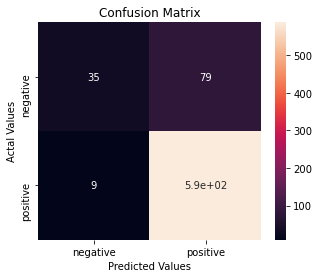

In [83]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [84]:
recall_score(y_val_bin, prediction, average = 'weighted')

0.8760563380281691

In [85]:
print(metrics.classification_report(y_val_bin, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.795     0.307     0.443       114
           1      0.881     0.985     0.930       596

    accuracy                          0.876       710
   macro avg      0.838     0.646     0.687       710
weighted avg      0.868     0.876     0.852       710



### Tf-idf Vectorizer Multinomial Naive Bayes

In [86]:
X_train_vec, X_val_vec = prepare_transformed_datasets(TfidfVectorizer(), X_t_bin, y_t_bin, X_val_bin, y_val_bin)

In [87]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t_bin, X_val_vec)

In [88]:
accuracy_score(y_val_bin, prediction)

0.847887323943662

In [89]:
cm = confusion_matrix(y_val_bin, prediction)
cm

array([[  6, 108],
       [  0, 596]])

In [90]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])

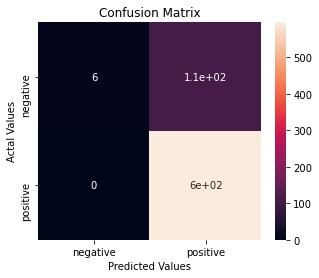

In [91]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [92]:
print(metrics.classification_report(y_val_bin, prediction, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.053     0.100       114
           1      0.847     1.000     0.917       596

    accuracy                          0.848       710
   macro avg      0.923     0.526     0.508       710
weighted avg      0.871     0.848     0.786       710



## Random Forest with Countvectorization

In [121]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t_bin, y_t_bin, X_val_bin, y_val_bin)

In [122]:
prediction, model = train_predict_model(RandomForestClassifier(n_estimators=1000, max_features=100, max_depth=10), X_train_vec, y_t_bin, X_val_vec)


In [123]:
accuracy_score(y_val_bin, prediction)

0.8436619718309859

In [124]:
cm = confusion_matrix(y_val_bin, prediction)
cm

array([[  3, 111],
       [  0, 596]])

## Multi-Classification Model

In [96]:
X = tweet_df['tweet_text'].astype(str)
y = tweet_df['category_id']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42, stratify=y)

In [98]:
token_tweets = [tweet_preprocessor(tweet, sw) for tweet in X_train]

['sxswi', 'hold', 'secret', 'show', 'ft', 'mister', 'heavenly', 'michael', 'cera', '5', 'free', 'beer', '4', 'location']
['nadya', 'direkova', 'riff', 'sid', 'meier', 'user', 'engagement', 'w', 'game', 'mechanic', 'reward', 'user', 'first', '10', 'minute']
['conf', 'everyone', 'mac', 'ipad', 'include', 'happen', 'pc', 'become', 'obsolete']
['heard', 'apple', 'go', 'open', 'special', 'store', 'expecting', 'lot', 'customer']
['hear', 'ex', 'apple', 'ex', 'pentagram', 'industrial', 'designer', 'really', 'cool', 'perspective', 'gsdm']
['like', 'vega', 'ce', 'iphone', 'best', 'use', 'hand', 'warmer']
['compete', 'circle', 'socialflow', 'board', 'resonant', 'topic']
['devops', 'provider', 'cloudkick', 'monitor', 'pagerduty', 'page', 'dnsmadeeasy', 'postmark', 'ec2', 'azure', 'google']
['official', 'app', 'go', 'android', 'iphone', 'ipad']
['try', 'make', 'detailed', 'colour', 'cod', 'google', 'calendar', 'prove', 'really', 'tough', 'also', 'get', 'organize']
['new', 'ubersocial', 'iphone', '

['conan', 'asst', 'lot', 'hipster', 'look', 'man', 'w', 'fedora', 'ipad', '2', 'lol']
['win', 'openbeta6', 'ipad', 'panel', 'today', '11', 'usguys', 'cc', 'dgtltribe', 'sxswbuffalo']
['bring', 'google', 'map', 'rerouted', 'image', 'jcpenney', 'image', 'macys', 'trashy', 'restraunts', 'comment', 'uosxsw']
['rt', 'set', 'edchat', 'musedchat', 'sxswi', 'newtwitter']
['awesome', 'conversation', 'network', 'line', 'apple', 'store']
['rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'via']
['iphone', 'app', 'awesome', 'lineup', 'amaze', 'really', 'look', 'forward', 'hang', 'guy']
['hey', 'lucky', 'duck', 'head', 'want', 'win', 'ipad', 'client', 'give', 'one', 'away', 'detail', 'sxswi']
['rt', 'heard', 'apple', 'pop', 'store', 'downtown', 'austin', 'pic', 'already', 'gowalla', 'pop', 'pop']
['android', 'developer', 'go']
['rt', 'rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'cont']
['new', 'film', 'year', 'folk',

['rt', 'next', 'head', 'design', 'ipad', 'apps', 'baby', 'boomer', 'wish', 'apps', 'yet', 'tg']
['enjoy', 'ride', 'anywhere', 'austin', '10', 'download', 'groundlink', 'app', 'booth', '437']
['guy', 'kawasaki', 'ex', 'apple', 'evangelist', 'talk', 'eloquently', 'art', 'enchantment', 'change', 'heart', 'mind', 'action']
['apple', 'open', 'pop', 'store', 'austin', 'geekfest', 'apple', 'apple', 'brianlam', 'ipad2']
['go', 'today', 'share', 'photo', 'video', 'ireport', 'cnn', 'iphone', 'app']
['pubcamp', 'kirkus', 'download', 'qrank', 'ipad', 'iphone', 'come', 'pubcamp', '2011', 'prize']
['idea', 'quietly', 'launch', 'hotpot', 'review', 'product', 'last', 'fall', 'outoftheloop', 'look']
['time', 'ever', 'torrent', 'also', 'legal', 'also', 'also', 'excite']
['marissa', 'mayer', 'location', 'contextual', 'discovery', 'enable', 'mobile', 'device', 'make', 'u', 'efficient', 'e', 'g', 'google', 'place', 'w', 'hotpot']
['still', 'use', 'original', 'first', 'generation', 'iphone', 'wonder', 'get'

['one', 'must', 'apps', 'survive', 'join', 'sxswbarcrawl', 'sxswi']
['rt', 'pepsicostage', 'yesterday', 'check', 'bag', 'may', 'ipad', 'screen', 'tell', 'mine']
['yup', 'rt', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['group', 'chat', 'apps', 'tell', 'l', 'two', 'apps', 'yet', 'avail', 'android', 'point', 'need', 'phone', 'apps']
['wait', 'eagerly', 'google', 'launch', 'secret', 'new', 'social', 'network', 'call', 'circle', 'today', 'new', 'update']
['people', 'line', 'team', 'android', 'award']
['rt', 'fun', 'google', 'pic']
['apple', 'open', 'temporary', 'store', 'austin', 'ipad', '2', 'launch']
['glad', 'hear', 'chance', 'create', 'iphone', 'case', 'u', 'yet', 'let', 'make', 'happen', 'zazzlesxsw']
['rt', 'google', 'circle', 'take', 'facebook', 'circle']
['dislike', 'people', 'constantly', 'look', 'iphone', 'ipad', 'would', 'lot', 'dislike']
['iphone', 'apps', 'keep', 'grooving', '2011', 'via']
['iphone', 'amigos', 'app', 'change', 'broadcast

['sound', 'like', 'job', 'detail', 'new', 'bomb', 'iphone', 'app', 'would', 'love', 'early', 'ado']
['flipboard', 'add', 'instagram', 'photo', 'social', 'search', 'apps', 'apple', 'socialsearch']
['queue', 'ipads', 'instead', 'party', 'honestly', 'geek', 'get', 'grip', 'rt', 'ipad', '2', 'take', 'video']
['danger', 'sit', 'floor', 'charge', 'laptop', 'ipod', 'iphone', 'etc', 'dread', 'dead', 'butt', 'damn', 'tingle', 'sxnewworlds']
['mike', 'tyson', 'punchout', 'today', 'feel', 'like', '1985', 'iphone', 'facial', 'tattoo', 'time', 'machine']
['google', '80', 'party', 'maggie', 'maes', 'get', 'free', 'glow', 'dark', 'shade']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['iphone', 'android', 'apps', 'keep', 'grooving']
['apple', 'pop', 'store', 'event', 'like', 'u', 'think', 'could', 'least', 'put', 'extra', 'friggen', 'tower']
['tech', 'apple', 'save', 'set', 'open', 'pop', 'store', 'despite', 'two', 'austin', 'texas', 'location', 'tec

['setup', 'demo', 'restaurant', 'page', 'sign', 'download', 'iphone', 'app', 'check', 'say', 'hi', 'sxswi']
['rt', 'get', 'look', 'rumor', 'apple', 'pop', 'store', 'austin']
['win', 'free', 'ipad', '2', 'webdoc', 'com', 'rt']
['anyone', 'pop', 'apple', 'store', 'austin', 'gotta', 'hop', 'place', 'today']
['expect', 'mob', 'scene', 'w', '6th', 'st', 'congress', 'ipad2']
['scavenger', 'hunt', 'game', 'business', 'release', 'app', 'iphone']
['could', 'spend', 'teach', 'theater', 'alone', 'look', 'schedule']
['go', 'send', 'ipad', 'mail', 'office', 'finish']
['deal', 'w', 'white', 'freeze', 'screen', 'far', 'much', 'everyone', 'iphone', 'make', 'conversion', 'possibility', 'efficient']
['google', 'aclu', 'party', 'tonight', 'best', 'thing', 'ever', 'apparently', 'spazmatics', 'franchise', 'band', 'rock']
['rt', 'qagb', 'timely', 'rt', 'bing', 'search', 'engine', 'share', 'continue', 'rise', '13', '6', 'google', 'still', 'top', '65', '4']
['stream', 'ipad', 'go']
['2', 'year', 'time', 'save

['flipboard', 'launch', 'iphone', 'app', 'later', 'year', 'via']
['organic', 'unveils', 'broadfeed', 'social', 'news', 'app', 'ipad', 'audience', 'get', 'head', 'door']
['rt', 'wait', 'see', 'big', 'news', 'google', 'circle']
['rt', 'fodder', 'snubor', 'panel', 'right', 'forget', 'gain', 'traction', 'europe', 'cause', 'issue', 'google']
['news', 'sxswi', 'apple', 'temporary', 'ipad', 'store', 'wth']
['charity', 'implication', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['apple', 'congress', 'nice', 'rt', 'apple', 'set', 'open', 'popup', 'shop', 'core', 'action', 'apple']
['client', 'android', 'get', 'really', 'buggy', 'lately', 'blame']
['anyone', 'know', 'apple', 'store', 'still', 'ipads', 'likely', 'run', 'today']
['anyone', 'make', 'cooler', 'rt', 'launch', 'groupon', 'live', 'social', 'type', 'reward']
['apple', 'pop', 'store'

['rt', 'apple', 'v', 'android', 'thing', 'go', 'tomorrow']
['rt', 'tweet', 'register', 'exclusive', 'pass', 'event', 'party', 'ipad', '2', 'give', 'liberty', 'free', 'sxswpass']
['enchantment', 'one', 'use', 'windows', 'voluntarily', 'apple', 'great', 'collection', 'egomaniac', 'history', 'haha']
['rt', 'style', 'x', 'brother', 'pop', 'ups', 'theatlantic', 'com', 'technology', 'archive', '2011', '03', 'apple', 'set', 'temporary', 'megastore', '72296']
['seriously', 'consider', 'leave', 'macbook', 'pro', 'home', 'fly', 'solo', 'ipad', 'week', 'think', 'make', 'work']
['google', 'say', 'future', 'around', 'ie', 'location', 'cnn']
['apple', 'set', 'open', 'popoup', 'shop', 'austin']
['rt', 'ipad', '32', 'gb', 'giveaway', 'follow', 'retweet', 'message', 'enter', 'sxswi', 'samsungsxsw']
['hey', 'iphone', 'love', 'turn', 'art', 'iphone', 'case', 'let', 'u', 'know', 'zazzlesxsw']
['rt', 'send', 'waaaambulance', 'rt', 'get', 'ipad', '2', 'yes', 'depress']
['manufacturing', 'serendipity', 'acce

['social', 'important', 'google', 'screw', 'big', 'launch', 'circus', 'socialmedia']
['two', 'guy', 'google', 'doodle', 'team', 'talk', 'fun', 'making', 'homepage', 'pretty']
['rt', 'simple', 'gesture', 'ipad', 'use', 'core', 'interaction', 'touchingstories']
['ipad', '2', 'good', 'product', 'time', 'make', 'worthwhile', 'improvement', 'diller']
['omgz', 'makeshift', 'apple', 'store', 'gold', 'gym']
['right', 'wow', 'rt', 'wiebe', 'walk', 'conceptual', 'graphing', 'loving']
['rt', 'apple', 'two', 'austin', 'area', 'retail', 'location', 'anticipation', 'gadget', 'ipad', 'gadget']
['rt', 'hey', 'austin', 'know', 'little', 'iphone', 'android', 'love', 'music', 'wanna', 'make', '20', 'hour', 'please', 'let', 'know']
['get', 'iphone', 'android', 'app', 'im', 'back', 'phone', 'gap', 'session', 'show', 'app', 'get', 'window', 'phone', 'marketplace', 'free']
['ipad', 'go', 'sale', 'friday', 'day', 'start', 'wonder', 'many', 'attendee', 'spend', 'friday', 'standing', 'line', 'gsdm']
['design', 

['gear', 'make', 'splash', 'launch', 'groupon', 'live', 'social', 'type', 'reward', 'boom']
['curious', 'google', 'circle', 'rumor', 'new', 'take', 'next', 'social', 'network', 'stay', 'tune', 'news']
['ux', 'uxdes', 'talk', 'really', 'exploration', 'wild', 'wild', 'west', 'ipad', 'design']
['rt', 'foursquare', '3', '0', 'time', 'wonder', 'iphone', 'android', 'guy', 'get', 'time']
['anyone', 'show', 'iphone', 'charger', 'need', 'tweet', 'joke', 'beard', 'text', 'ppl', 'make', 'jealous']
['writer', 'ipad', 'app', 'save', 'ass', 'flight', 'big', 'panel', 'good', 'job']
['papyrus', 'sort', 'like', 'ipad', 'nice', 'lol', 'lavelle']
['back', 'big', 'apple', 'need', 'wean', 'new', 'foursquare', 'addiction', 'thanks', 'people', 'really', 'care', 'nah']
['ipad', '2', 'go', 'sale', 'next', 'friday', 'austin', 'apple', 'store', 'go', 'busy']
['technews', 'time', 'foursquare', 'ups', 'game', 'tech', 'news', 'friend', 'offer', 'iphone', 'game', 'tech']
['josh', 'clark', 'session', 'ipad', 'tablet'

['rt', 'best', 'thing', 'heard', 'wknd', 'give', 'ipad', '2', 'money', 'japan', 'relief', 'need', 'ipad', '2']
['even', 'begin', 'apple', 'win', 'win', 'big']
['great', 'see', 'u', 'rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['rt', 'rumor', 'apple', 'store', 'open', '6th', 'congress', 'sign', 'point', 'yes']
['yes', 'line', 'front', 'confirm', 'pop', 'apple', 'store']
['gsdm', 'google', 'party', 'hook']
['dude', 'next', 'hold', 'use', 'ipad', '2', 'like', 'trophy', 'lookingforwardtothemusicfest']
['also', 'gonna', 'google', 'finally', 'know', 'mean', 'see', 'pas', 'twitter', 'enough', 'time', 'gotta', 'find']
['anyone', 'attend', 'google', 'aclu', 'party', 'could', 'plz', 'picture', 'thanks']
['bad', 'apple', 'show', 'late', 'shoot', 'ideas', 'leave', 'early', 'meeting', 'personality', '2', 'gamestorming']
['privacybootcamp', 'startup', 'sound', 'like', 'fight', 'wait', 'happen', 'add', 'orin', 'hatch']
['iphone', 'battery', 'make']
['t

['new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponsor', 'mashable']
['line', 'ipads', 'look', 'bad', 'wait', '6', '5', 'hour', 'iphone', '4']
['rt', 'best', 'thing', 'heard', 'give', 'ipad', '2', 'money', 'japan', 'relief', 'need', 'ipad', '2', 'sxswgood']
['time', 'atx', 'apple', 'open', 'pop', 'store', 'debut', 'cool', 'amex', 'partnership', 'even', 'start', 'till', 'fri']
['3', 'v', 'groupon', 'live', 'social', 'type', 'reward', 'battle', 'begin']
['rt', 'love', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['apple', 'school', 'marketing', 'expert']
['term', 'high', 'resonance', 'right', 'marisa', 'mater', 'google', 'map', 'place', 'hotspot']
['aol', 'mobile', 'launch', 'play', 'android', 'app', 'via']
['rt', 'give', 'away', 'ipad', '2', 'creator', 'popular', 'disc', 'interactive', 'create', 'disc', 'share', 'twitter']
['rt', 'question', 'inside', 'ipad', '2', 'fire', 'way']
['launch', 'product', 'plenty', 'else', 'ok',

['excite', 'tomorrow', 'leave', 'austin', '8am', 'see', 'google', '3', '30pm', 'still', 'work', 'schedule']
['buy', 'mophie', 'juice', 'pack', 'iphone', 'solely', 'cool', 'kid']
['rt', 'calvin', 'geek', 'charlie', 'sheen', 'goddess', 'schmittastic', 'google']
['today', 'last', 'day', 'apple', 'pop', 'vacation', 'start', 'tomorrow', 'great', 'experience']
['rt', 'rumor', 'google', 'launch', 'new', 'social', 'network', 'call', 'circle', 'today', 'sxswi']
['enough', 'already', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['checkout', 'league', 'extraordinary', 'hacker', 'lego', 'google']
['apple', 'open', 'makeshift', 'store', 'ipad2', 'available', '5pm', 'today', 'tempt']
['brand', 'focus', 'purpose', 'object', 'survive', 'succeed', 'google', 'search', 'useful', 'info', 'nike', 'sneaker', 'performance']
['line', 'already', 'form', 'apple', 'pop', 'store', 'austin', 'people', 'see', 'festival']
['need', 'ipad', 'get', 'one', 'apple', 'pop

['technews', 'win', 'hint', 'answer', 'every', 'year', 'tech', 'news', 'bill', 'murray', 'iphone', 'tech']
['rt', 'spend', 'aftrnoon', 'frozen', 'lake', 'photograph', 'brother', 'scott', 'team', 'catch', 'th', 'weeknd']
['rt', 'ironic', 'google', 'direction', 'party', 'end', 'walk', '6', 'block', 'wrong', 'direction', 'time', 'bed', 'think']
['rt', 'peter', 'cashmore', 'ipad', '2', 'minor', 'improvement', 'worth', 'unless', 'money', 'burn']
['apple', 'open', 'temp', 'store', 'austin', 'via', 'ipad2']
['cool', 'yes', 'happy', 'b', 'day', 'rt', 'new', 'post', 'business', 'card', 'dead']
['live', 'photo', 'apple', 'store', '10x2', 'sehugg', 'kshepherd', 'juntao', 'wuchangtx', 'ipad']
['rt', 'rt', 'tweet', 'register', 'exclusive', 'pass', 'event', 'party', 'ipad', '2', 'liberty', 'free', 'sxswpass']
['rt', 'wonder', 'many', 'ipads', 'sell', 'rt', 'open', 'pop', 'store']
['launch', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'via', 'interest', 'jl']
['rt', 'leave', 'tradesho

['apple', 'open', 'ipad', '2', 'pop', 'store', 'austin', 'could', 'strategy', 'work', 'bookselling']
['google', 'try', 'launch', 'new', 'social', 'network', 'call', 'circle', '310409h2011']
['rt', 'apple', 'pop', 'shop', 'lavaca', '6th', 'yes', 'line', 'wrap', 'around', 'block', 'apple', 'store']
['idea', 'combine', 'google', 'analytics', 'tool', 'know', 'website', 'program', 'something', 'bavcid']
['rt', 'alarm', 'go', 'allow', 'user', 'generate', 'content', 'say', 'google', 'richard', 'salgado', 'privacybootcamp']
['search', 'temporary', 'apple', 'store']
['get', 'ready', 'hear', 'road', 'map', 'vp', 'product', 'marissa', 'mayer', 'pls', 'tell', 'go', 'focus', 'search']
['rt', 'rt', 'new', 'google', 'tool', 'measure', 'everything', 'display', 'one', 'place', 'almost', 'make', 'cry', 'happy', 'thank', 'bavcid']
['take', 'video', 'ipad', '2', '6th', 'street', 'smart', 'cover', 'rad', 'film', 'huge', 'display', 'nut', 'look', 'great', 'playback']
['rt', 'go', '1', '1', 'android', 'live'

['hbd', 'donate', 'dime', 'rt', 'everyone', 'come', 'friendly', 'reminder', 'ipad', '2', 'friday', 'birthday', 'saturday']
['discuss', 'salsa', 'ingredient', 'industry', 'party', 'welivehere', 'gsdm']
['need', 'get', 'ipad', '2', 'right', 'away', 'apple', 'open', 'pop', 'store', 'west', '6th', 'congress']
['co', 'founder', 'google', 'teacher', 'academy', 'bring', 'hs', 'student', 'austin', 'show', 'use', 'tech', 'education']
['get', 'copy', 'enchantment', 'ipad', 'kindle', 'today', 'excite', 'thx', 'keep', 'world', 'enchant', 'glad']
['70', 'mobile', 'hit', 'texas', 'tribune', 'come', 'apple', 'device', 'cor', 'via', 'niran', 'babalola']
['outside', '9', '30', 'panel', '75', 'people', 'skip', 'barely', 'get', 'anything', 'work', 'iphone', 'need', 'shrink', '10k', 'people']
['zazzle', 'gear', 'hit', 'look', 'tweet', 'come', 'create', 'iphone', 'case', 'zazzlesxsw']
['new', 'iphone', 'new', 'ipad', '2', 'come', 'run', 'fast', 'cuz', 'every', 'girl', 'crazy', 'sharp', 'mac', 'man', 'strum

['rt', 'great', 'meeting', 'haha', 'hollergram']
['rt', 'weather', 'change', 'today', 'get', 'exclusive', 'weather', 'update', 'kxan', 'austin', 'jim', 'spencer']
['great', 'talk', 'must', 'one', 'apple']
['google', '80', 'party', 'maggie', 'hair', 'makeup', 'rockin']
['next', 'ding', 'dong', 'google', 'bing', 'search', 'listing']
['heartbreaker', 'apple', 'ipad2', 'rt', 'ask', 'sadly']
['yo', 'iphone', 'app', 'illa', 'def', 'go']
['apparently', 'line', 'get', 'ipad', 'store', 'grow', '2', 'block', '5', 'block', 'past', '30', 'min', 'wut']
['iphone', 'app', 'unreal', 'click', 'location', 'leanstartup', 'person', 'tell', 'still', 'seat']
['check', 'event', 'via', 'google', 'map', 'lot', 'buzz', 'overthere']
['update', 'heading', 'apple', 'store', 'buy', 'ipad']
['google', 'tv', 'ipad', 'app', 'connect', 'tv', 'experience', 'talk', 'super', 'rad', 'sxsw11']
['yet', 'walk', 'conference', 'room', 'look', 'like', 'apple', 'ad', 'think', 'nothing', 'else']
['rt', 'html5', 'shirt', 'google', 

['rt', 'engage', 'filter', 'iphone', 'ipod', 'twitter', 'app', 'youkidshavefun']
['rt', 'important', 'make', 'sure', 'donate', 'japanese', 'red', 'cross', 'japan', 'sxswcares', 'quake']
['rt', 'android', 'app', 'review', 'go', 'pls']
['rt', 'explanation', 'continue', 'success', 'apple', 'existence', 'god', 'enchantment']
['csr', 'report', 'janecek', 'microsoft', 'give', 'charity', 'apple', 'give', 'nothing', 'everyone', 'room', 'iphone', 'drive', 'decision']
['rt', 'forget', 'come', 'privacybootcamp', 'startup', 'aclu', 'acc', '9abc', '3', '30']
['rt', 'enjoy', 'california', 'hollywood', 'silicon', 'valley', 'meet', 'nyc', 'sunny', 'austin', 'pool', 'cowboy', 'boot', 'ipad', 'vibe', 'sxswi']
['google', 'circle', 'new', 'social', 'medium', 'site', 'wow']
['rt', 'lbseverywhere', 'finkelstein', '206k', 'location', 'aware', 'apps', 'io', 'android']
['rt', 'apple', 'open', 'pop', 'store', 'downtown', 'austin', '1st', 'floor', 'bldg', '6th', 'congress', 'ipad', '2', 'launch', 'morefunpeoplew

['like', 'ipoo', 'app', 'iphone', 'ha', 'rt', '4chan', 'internet', 'bathroom', 'wall', 'sxswmoot']
['happy', 'discovr', 'name', 'one', 'top', 'ten', 'must', 'apps', 'ipad', '2', 'fight', 'way', 'thru', 'queue']
['rt', 'nothing', 'say', 'douche', 'cake', 'like', 'walk', 'around', 'ipad', 'like', 'iphone']
['experiment', 'crucial', 'google', 'brand', 'say', 'marissa', 'mayer', 'marissagoogle']
['surprised', 'local', 'news', 'austin', 'mention', 'traffic', 'implication', 'apple', 'pop', 'store', 'launch', 'today']
['nick', 'time', 'get', 'iphone', 'eventseekr', 'app']
['rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch', 'rgv']
['go', 'apple', 'store', 'kingston', 'friends', 'new', 'ipad', 'get', 'something', 'cheer']
['downloadfree', 'track', 'music', 'sampler', 'available', 'green', 'lady', 'killer']
['pretty', 'excited', 'apple', 'pop', 'store', 'come']
['protip', 'avoid', 'austin', 'area', 'apple', 'store', 'friday']
['thx', 'rt', 'rt', 'bad', '

['many', 'austin', 'follow', 'find', 'googlers']
['rt', 'thanks', 'everyone', 'make', 'great', 'day', 'shop', 'today', 'austin', 'come', 'see', 'u', 'tomorrow']
['free', 'jam']
['ungrateful', 'bc', 'much', 'shit', 'play', 'turn', 'shit', 'iphone']
['rt', 'oh', 'vimeo', 'iphone', 'app', 'submit', 'store', 'smart', 'upload', 'continue', 'leave', 'service', 'drop', 'li', 'video']
['day', '1', 'marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'world', 'mobile']
['oh', 'texas', 'social', 'medium', 'award', 'need', 'ask', 'mother', 'anymore', 'google', 'sxswi']
['iron', 'mike', 'rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['love', 'apple', 'smart', 'enough', 'popup', 'store', 'story', 'map', 'tip']
['rt', 'impulsive', 'buy', 'friends', 'one', 'selling', '1st', 'gen', '32gb', '3g', 'ipad']
['even', 'begin', 'apple', 'win']
['new', 'www', 'divasanddorks', 'com', 'apple', 'ipad', '2', 'invades']
['almost', 'every', 'answered', 'w', 

['hey', 'twitter', 'need', 'way', 'u', 'disaster', 'area', 'filter', 'thing', 'like', 'ipad', 'right', 'really', 'care']
['ipad', '2', 'rear', 'face', 'camera', 'get']
['gary', 'start', 'new', 'show', 'daily', 'grape', 'iphone', 'thankyouecon']
['david', 'carr', 'nyt', 'austin', 'give', 'drunken', 'interview', 'cnn', 'want', 'app', 'transport', 'around', 'nyc', 'sits', 'ipad']
['rediculous', 'overflow', 'line', 'ipad', 'session', 'sxswsmall', 'interesting', 'talk', 'like', 'say', 'miss', 'ipad', 'talk']
['rt', 'love', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'hear']
['rt', 'go', 'beyond', 'border', 'edchat', 'musedchat', 'sxswi', 'classical', 'newtwitter']
['rt', 'win', 'picture', 'android', 'google']
['anyone', 'bring', 'ipad', 'v', 'computer']
['help', 'decide', 'panel', 'go', 'next', 'future', 'social', 'photography', 'google', 'doodle', 'burn', 'man', 'pac', 'man', 'beyond']
['rt', '97', 'farmer', 'mobile', 'phone', '43', 'smartphone', 'marketshare', 'bb', '33', '18', 

['location', 'base', 'fast', 'fun', 'future', 'via']
['accord', 'google', 'marissa', 'mayer', 'future', 'location', 'augment', 'reality', 'contextual', 'discovery', 'make', 'smartphones', 'smarter', 'fb']
['celebrate', 'beauty', 'web', 'msft', 'ie9', 'launch', 'play', 'new', 'html5', 'game', 'win', 'ipad2']
['rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['delightful', 'reprieve', 'spot', 'something', 'plug', 'ipad', 'flat', 'iron', 'bless', 'lady', 'friend', 'bless']
['arrive', 'issue', 'resolve', 'die', 'use', 'iphone', 'app', 'cant', 'login', 'rt']
['free', 'itunes', 'take', 'itunes', 'store']
['chris', 'sacca', 'tweet', 'fake', 'beta', 'invite', 'follower', 'swarm', 'ensues', 'techcrunch', 'chris', 'sacca', 'tweet', 'apple']
['mayer', 'also', 'admit', 'google', 'need', 'step', 'customer', 'support', 'google', 'map']
['effectively', 'kill', '3rd', 'party', 'developer', 'base', 'ismparty']
['stop', 'booth', '206', 'win', 'ipad2']

['rt', 'learn', 'google', 'search', 'jesus', 'star', 'war', 'much', 'allhat']
['group', 'texting', 'war', 'heat', 'fast', 'society', 'launch', 'new', 'android', 'app', 'update', 'iphone', 'app', 'mobilenews']
['every', 'person', 'see', 'ipad', 'look', 'crazy', 'look', 'like', '80', 'cell', 'phone', 'hand']
['attn', 'rt', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['get', 'ready', 'instal', 'iphone', 'woot']
['get', 'ipad', '2', 'save', 'back', 'lug', 'laptop', 'sxswmymistake']
['rt', 'thanks', 'rt', 'try', 'contact', 'friend', 'family', 'japan', 'create', 'person', 'finder']
['mean', 'percentage', 'io', 'vs', 'android', 'v', 'blackberry', 'etc']
['iphone', 'go', 'sleep', 'prepare', 'sleep', '30', '45', 'minute', 'pr']
['todo', 'q', 'google', 'bing', 'rank', 'mon', '12', '30pm']
['evernote', 'iphone', 'awesome', 'note', 'photo', 'taccsxsw']
['posterous', 'join', 'pile', 'posterousevents', 'iphone', 'via', 'tool', 'photo', 'apps']
['massive', 'lin

['noticed', 'dst', 'come', 'weekend', 'many', 'iphone', 'user', 'hour', 'late', 'come', 'sunday', 'morning', 'iphone']
['fantasy', 'bracket', 'challenge', 'ipad', '2', 'giveaway', 'via', 'constantcontact', 'marchmadness', 'selectionsunday']
['rumor', 'apple', 'popup', 'store', 'downtown', 'austin', 'ipad', '2', 'launch', 'smart', 'move', '1of', 'many', 'dfcbto']
['google', 'arwords', 'arsense', 'anyone', 'arsxsw', 'darknet']
['thing', 'get', 'smarmcake', 'writeup', 'google', 'ontologists', 'ontologyshoutoutwut']
['even', 'bear', 'yet', 'rt', 'google', 'party', 'theme', 'party', 'like', '1986', 'maggie', 'mae', 'pic']
['twitter', 'full', 'people', 'buy', 'ipad', '2', 'least', 'pity', 'party', 'keep', 'busy', 'suppose']
['rt', 'gear', 'bag', 'ipad', '2', 'iphone', 'mophie', 'travel', 'light', 'year']
['beautiful', 'day', 'austin', 'come', 'grab', 'slice', 'two', 'check', 'google', 'get', 'deal', 'sxswi']
['check', 'ipad', 'design', 'headaches', '2', 'tablet', 'call', 'morning', 'tapworth

['new', 'competition', 'q2', 'google', 'check', 'offer', 'smccolumbus']
['rt', 'marc', 'ecko', 'launch', 'iphone', 'app', 'autodial', 'political', 'change', 'edreform', 'edtech', 'eduvc', 'fightthepaddle']
['apple', 'popup', 'store']
['lose', 'way', 'care', 'much', 'business', 'tim', 'reilly']
['help', 'advance', 'getoutthevote', 'ipad', 'iphone', 'startup', 'cbus', 'cbustech']
['gd', 'idea', 'rt', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', '911tweets', 'panel']
['rt', 'ipad', '2', 'take', 'video']
['among', 'company', 'try', 'make', 'impression', 'interactive', 'sxswi']
['probably', 'right', 'time', 'surely', 'way', 'rt', 'venturebeat', 'get', 'social', 'texas', 'google', 'tech']
['post', 'facebook', 'deal', 'beluga', 'get', 'final', 'tune', 'tc', 'beluga', 'facebook', 'iphone']
['apple', 'set', '5', '000', 'square', 'foot', 'temporary', 'store', 'sell', 'new', 'ipads', 'test', 'potential', 'traffic']
['apple', 'offer', 'free', 'itunes', 'sampler', 'ahead', 'featu

['marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'world', 'mobile']
['wonder', 'apple', 'set', 'makeshift', 'shop', 'sell', 'ipad2', 'tomorrow']
['rt', 'haha', 'google', 'serve', 'pie', 'booth', '3', '14', '1', '59', 'pm']
['rt', 'zazzle', 'officially', 'come', 'grille', 'u', 'zazzlsxsw', 'get', 'make', 'iphone', 'case']
['saw', 'yesterday', 'hop', 'b', 'crowd', 'apple', 'ipad2']
['lent', 'marc', 'ecko', 'apple', 'remote', 'beprepared', 'fb']
['sad', 'head', '1pm', 'cst', 'today', 'win', 'vip', 'access', 'acoustic', 'solo', 'set']
['apple', 'open', 'temporary', 'apple', 'store', '6th', 'congress', 'tomorrow', 'march', '11', 'ipad', 'sale', 'miss']
['rt', 'plan', 'google', 'party', 'blackberry', 'party', 'ie', '8', 'party', 'good', 'time', 'party', 'lol']
['best', 'thing', 'abt', '1', 'sherry', 'patio', 'plenty', 'free', 'park', '5', '10', 'min', 'n', 'mess']
['rt', 'cameron', 'sinclair', 'spearhead', 'japan', 'disaster', 'relief', 'via', 'twitter', 'iphone']
['i21', 're

['rt', 'ipad', '2', 'sale', 'cc', 'sxswi', 'theinternet']
['interest', 'rt', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'rww', 'f6bcet']
['rt', 'come', 'see', 'bitbop', 'austin', 'gdgtaustin', 'purevolume', 'house', '504', 'trinity', 'monday', 'march', '14th']
['google', 'connect', 'digital', 'physical', 'world', 'mobile', 'via']
['new', 'blogpost', 'google', 'announce', '60', 'checkins', 'austin', 'texas', 'icnnreport', 'post', 'scrm']
['buzz', 'billing', 'entrepreneurs', 'win', 'tech', 'award', 'via', 'technology']
['rt', 'everyone', 'already', 'one', 'anti', 'theft', 'protection', 'leave', 'laptop', 'ipad', 'go', 'get', 'latte']
['rt', 'rt', 'per', 'rumor', 'google', 'may', 'preview', 'big', 'social', 'strategy', '80', 'theme', 'costume', 'party', 'yep', 'cn']
['hmm', 'ipad', 'interface', 'talk', 'ux', 'research', 'hmm', 'like', 'sound', 'politi

['rt', 'cool', 'mean', 'watch', 'ustream', 'skyfire', 'browser', 'iphone', 'safari', 'work', 'fun']
['austin', 'ipad', '2', 'line', '1', '75', 'block', 'long', 'line', 'enjoy', 'spectacle']
['god', 'like', 'imac', 'macbook', 'iphone', 'blackberry', 'star', 'enough', 'time', 'read', 'book', 'remember']
['go', 'game', 'new', 'lbs', 'scavenger', 'hunt', 'launch', 'service', 'create', 'customized', 'game', 'event', 'via']
['cue', 'hype', 'rt', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'circle']
['poke', 'like', 'tweeted', 'google', 'love', 'story', 'alisa', 'icrossing', 'futurefifteen']
['rt', 'compete', 'circle', 'socialflow', 'board', 'resonant', 'topic']
['yea', 'another', 'google', 'product', 'available', 'google', 'apps', 'yet', 'google', 'hotpot']
['line', 'form', 'popup', 'apple', 'store', 'sign', 'apple', 'yet']
['questioner', 'say', 'thanks', 'big', 'fan', 'google', 'cause', 'giggle', 'audience', 'laugh']
['quick', 'encourage', 'seo', 'pract

['saw', 'ur', 'article', 'group', 'texting', 'check', 'smyle', 'android', 'web', 'apps', 'feature', 'group', 'chat', 'whiteboard']
['mr', 'heavenly', 'aka', 'band', 'w', 'michael', 'cera', 'ready', 'rock', 'bat', 'bar', 'iphone', 'camera', 'de', 'rigeur']
['geeky', 'love', 'rt', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['rt', 'yes', 'rumor', 'true', 'come', 'play', 'ipad', 'booth', 'exhibit', 'hall', '3', 'ipad', 'ipad2', 'giant']
['stay', 'alive', 'indie', 'iphone', 'game', 'development', 'survive', 'acc', 'room', '12ab', 'w', '22', 'others']
['google', 'belong', 'u']
['rt', 'rt', 'heard', 'apple', 'pop', 'store', 'dtwn', 'austin', 'pic', 'already', 'gowalla', 'pop', 'pop']
['wish', 'excellent', 'day', 'today', 'get', 'ipad', 'envy']
['best', 'session', 'see', 'far', 'morning', 'music', 'ixd', 'design', 'ipad', 'interface', 'win']
['protect', 'privacy', 'like', '2011', 'party', 'w']
['c9', 'first', 'cut', 'code', 'valid', '8', '00', '11', '59

['rt', 'rt', 'shiny', 'new', 'eightbit', 'apps', 'new', 'garyvee', 'book', 'pop', 'ipad', '2', 'store', 'christmas', 'nerd']
['google', 'come', 'social', 'network', 'mean', 'work', 'something', 'though', 'technews']
['apple', 'smart', 'open', 'pop', 'store', 'austin', 'crowd']
['crowd', 'swarm', 'ipad', '2', 'launch', 'via']
['rt', 'excite', 'see', 'hls', 'dynamic', 'video', 'ad', 'insertion', 'tv', 'everywhere', 'work', 'ipad2', 'later', 'today', 'popup', 'apple', 'store']
['chat', 'via', 'iphone', 'hilarious']
['attend', 'preso', 'live', 'simply', '100tc', 'sxswi', 'felt', 'bit', 'guilty', 'take', 'note', 'new', 'ipad']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'rt']
['oh', 'download', 'free', 'iphone', 'app', 'sort', 'social', 'networking', 'kind', 'thing', 'fail']
['good', 'morning', 'r', 'u', 'talk', 'abt', 'twitter', 'accord', 'ipad', 'design', 'geogames', 'design', 'headache']
['mass', 'google', 'zation', 'rank', 'index', 'e

['gotta', 'admit', 'apple', 'pop', 'shop', 'thing', 'pretty', 'brilliant', 'someone', 'aapl', 'know']
['apple', 'customer', 'service', 'top', 'notch', 'even', 'get', 'guy', 'hang', 'line', 'give', 'inventory', 'update', 'nice']
['google', 'see', 'search', 'engine', 'organizer', 'information', 'give', 'path', 'innovate', 'new', 'product', 'savebrands']
['rt', 'launching', 'product', 'plenty', 'else', 'join', 'u', 'h4ckers', '80', 'dance']
['rt', 'still', 'ipad', '2', 'least', 'pop', 'apple', 'store', 'buy', 'one']
['wow', 'big', 'apple', 'attend', 'bring', 'along', 'temporary', 'store']
['google', 'say', 'want', 'give', 'lightning', 'talk', 'h4ckers', 'audience', 'tonight', 'email', 'ben', 'mcgraw', 'gmail', 'com', 'spot', 'stage']
['aight', 'wed', 'thurs', 'list', 'possibility', 'hope', 'see', 'twitter', 'bud', 'atx', 'week']
['rt', 'wonder', 'street', 'closure', 'make', 'google', 'map', 'show', 'austin']
['rt', 'want', 'win', 'ipad', 'get', 'case', 'chaos']
['love', 'apple', 'let', 's

['rt', 'download', 'free', 'sampler', 'band', 'play']
['iphone', '4', 'case', 'rad', 'ready', 'stop', 'tomorrow', 'get', 'zazzlesxsw', 'sxswi']
['rt', 'next', 'year', 'go', 'set', 'bootleg', 'sidewalk', 'cart', 'austin', 'sell', 'macbook', 'power', 'adapter', 'iphone', 'cable', 'oh', 'red', 'bull']
['rt', 'enter', 'contest', 'maybe', 'win', 'ipad', '2']
['rt', 'rt', 'marissa', 'mayer', 'google', 'connect', 'digital', 'physical', 'world', 'mobile']
['apple', 'open', 'pop', 'store', 'time', 'ipad2', 'sale']
['austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['rt', 'team', 'head', 'big', 'boi', 'show', 'thanks', 'crew', 'rt', 'find', 'owl', 'free', 'tattoo']
['rt', 'idea', 'combine', 'google', 'analytics', 'tool', 'know', 'website', 'program', 'something', 'bavcid']
['downtown', 'austin', 'apple', 'store', 'congress', 'west', '6th', 'street', 'answered', 'question', 'old', 'fashion', 'way', 'google']
['rt', 'rumor', 'apple', 'open', 'temporary', 'stor

['rt', 'cant', 'wait', 'give', 'samsung', 'people', 'demo', 'horrible', 'terrible', 'google', 'nexus', 'phone']
['anyone', 'know', 'apple', 'store', 'new', 'shipment', 'ipads', 'yet']
['rt', 'apple', 'build', 'pop', 'store', '3', 'day', 'open', '24', '7', 'selling', 'ipad', '2']
['wooooo', 'apple', 'store', 'downtown', 'austin', 'open', 'til', 'midnight']
['photo', 'make', 'austin', 'make', 'make', 'party', 'host', 'google', 'aclu']
['inside', 'ipad', '2', 'chip', 'bring', '50', 'browsing', 'boost', 'rt', 'best', 'hungry', 'tip', 'mekong', 'river', 'g']
['sit', 'ground', 'wait', 'ipad', 'austin', 'apple', 'popup', 'store', 'geek']
['rt', 'google', 'map', 'route', 'around', 'traffic', 'save', 'user', '2', 'year', 'every', 'day', 'marissa', 'mayer']
['apple', 'open', 'temporary', 'store']
['hear', 'google', 'may', 'launch', 'social', 'network', 'event', 'tonight']
['overload', 'info', 'deliver', 'google', 'kill', 'discovery', 'google', 'say', 'ppl', 'lose', 'curiosity', 'wonder', 'need',

['buy', 'buy', 'rt', 'even', 'begin', 'apple', 'win']
['buy', 'ipad', '2', 'yet', 'go', 'check', 'apple', 'pop', 'store']
['excite', 'wait', 'rt', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['user', 'drive', '12b', 'mile', 'year', 'google', 'map', 'navigation', 'jr']
['socialmuse', 'android', 'available', 'genius', 'lookalike', 'music', 'listening', 'appcircus']
['1', 'hour', 'ago', 'apple', 'store', 'downtown', 'austin', 'store', 'hundred', 'people', 'ipad2']
['apple', 'cocky', 'perhaps', 'separate', 'ipad2', 'store', 'would', 'good', 'idea', 'guess', 'need', 'extra', 'marketing']
['come', 'google', 'party', 'gsd', 'badge', 'get', 'u', 'free', 'food', 'drink', 'music', 'big', 'place', 'line', 'great', 'party', 'come']
['review', 'probably', 'download', 'torrent', 'make', 'thing', 'slow']
['cruisin', 'austin', 'check', 'venue', 'tomorrow', 'night', 'saw', 'looong', 'apple', 'ipad', 'line']
['either', 'go', 'wait', 'line', 'buy', 'trick', 'ipad',

['use', 'ipad', 'set', 'list', 'band']
['google', 'product', 'gatekeeper', 'marissa', 'mayer', 'location', 'base', 'fast', 'fun', 'future', 'ht']
['rt', 'mindjet', 'go', 'celebrate', 'give', 'away', 'ipad', '2', 'find', 'enter']
['rt', 'new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'conference', 'sxswi', 'assistivetech']
['android', 'iphone', 'chris', 'sacca', 'tweet', 'fake', 'beta', 'invite', 'follower', 'swarm', 'ensues', 'androidcrunch']
['app', 'iphone', 'ridiculous', 'personal', 'planner', 'next', '5', 'day']
['rt', 'austinites', 'check', 'iphone']
['anti', 'social', 'irl', 'type', 'ipad', 'social', 'tv', 'session', 'fill', 'fast', 'social', 'right', 'ironic']
['gsd', 'google', 'party', 'blow', 'mind', 'much', 'amaze', 'food', 'drink', 'music', 'photo', 'booth', 'fun']
['def', 'could', 'use', 'ipad', 'today', 'tweet', 'via', 'iphone', 'sorta', 'pretty', 'much', 'sux']
['rt', 'include', 'emotional', 'thing', 'ipad', 'barrydiller', 'pnid']
['rt', 'apple',

['walk', 'google', 'party']
['rt', 'rt', 'ipad', '2', 'take', 'video', 'sxswi']
['rt', 'love', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference']
['awesome', 'rt', 'happen', 'apple', 'hire', 'security', 'austin']
['register', 'private', 'beta', 'win', 'apple', 'tv', 'visit', 'detail']
['google', 'launch', 'social', 'network', 'google', 'circle']
['day', 'later', 'still', 'line', 'door', 'apple', 'store', 'ipad2']
['approach', 'soft', 'launch', 'plan', 'android', 'demo', 'run', 'flyer', 'print', 'shirt', 'pack', 'austin']
['wave', 'buzz', 'rt', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'circle']
['netflix', 'iphone', 'app', 'build', 'ridiculous', 'deadline', 'big', 'mistake', 'tech', 'part', 'agree']
['last', 'least', 'get', 'copy', 'stupid', 'game', 'plus', 'iphone', 'also', 'special', 'price']
['intend', 'bring', 'trusty', 'backpack', 'upcoming', 'trip', 'number', 'ipad', '2', 'help', 'buy', 'back', 'e', 'posible'

['contextual', 'discovery', 'search', 'combine', 'calendar', 'weather', 'flight', 'traffic', 'data', 'create', 'personalize', 'trip', 'advise', 'mayer', 'google']
['rt', 'long', 'line', 'apple', 'store', 'course']
['noh', 'donlot', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'cont']
['apple', 'ipad2', 'popup', 'store', 'like', 'red', 'cross', 'emergency', 'tent', 'hipster', 'lol', '3', 'publicradio']
['rt', 'wahoo', 'party', 'free', 'beer', 'tacos', 'ritas', 'thurs']
['crazy', 'look', 'around', 'realize', 'last', 'year', 'one', 'ipad']
['rt', 'flipboard', 'next', 'platform', 'iphone', 'ceo', 'say']
['browserwars', 'panel', 'without', 'apple', 'like', 'without', 'party']
['jealous', 'send', 'tweet', 'iphone', 'bitter']
['bettercloud', 'presenter', 'austin', 'native', 'john', 'wiley', 'happen', 'chief', 'engineer', 'behind', 'google', 'search']
['stock', 'mophie', 'juice', 'pack', 'apple', 'temp', 'store', 'open', 'austin', 'ipad', '2', 'launch', 'via']
['googl

['rt', 'launch', 'spin', 'ipad', 'app', 'ton', 'music', 'photo', 'videos', 'whatcha', 'think']
['cool', 'rt', 'update', 'npr', 'music', 'iphone', 'app', 'song', 'info', '4', 'song', '24', '7', 'live', 'video', 'stream', 'time', '4']
['download', '20', 'free', 'track', 'music', 'sampler', 'include']
['poster', 'saw', 'rt', 'google', 'tweet', 'new', 'think', 'speak', 'mark', 'belinsky', '911tweets', 'panel']
['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'get']
['course', 'bing', 'result', 'good', 'google', 'seo', 'qagb']
['grabbed', 'seat', 'ballroom', 'hear', 'google']
['good', 'q', 'purchase', 'ipad', '2', 'see', 'ppl', 'buying', 'white', 'one', 'nice', 'frame', 'presentation', 'read']
['next', 'last', 'panel', 'today', 'google', 'doodle', 'burn', 'man', 'pac', 'man', 'beyond', 'sxswi', 'googledoodles']
['lightbox', 'photo', 'want', 'new', 'android', 'camera', 'app']
['want', 'go', 'apple', 'pop', 'store', 'afraid', 'leave', 'new', 'ipad']
['tech', 'appl

['rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['google', 'dev', 'panel', 'indicate', 'android', 'screen', 'reader', 'work', 'widget', 'native', 'ui', 'web', 'view', 'browser']
['talk', 'ipad', 'design', 'great', 'example', 'insight', 'pick', 'copy', 'book']
['surprise', 'apple', 'open', 'pop', 'store', 'austin', 'nerd', 'town', 'get', 'new', 'ipads', 'http']
['false', 'alarm', 'google', 'circle', 'come', 'probably', 'ever', 'sxswi']
['google', 'photo', 'booth', 'six', 'lounge', 'check']
['rt', 'bore', 'keynote', 'use', 'ipad', 'draw', 'picture', 'even', 'good', 'artist', 'sxswi']
['marissa', 'miller', 'google', 'make', 'shout', 'khan', 'academy', 'great', 'thing', 'education', 'fmsignal', 'cc']
['rt', 'pubcamp', 'kirkus', 'download', 'qrank', 'ipad', 'iphone', 'come', 'pubcamp', '2011', 'prize']
['upside', 'start', 'today', 'ipad', '2', 'release']
['remind', 'abt', 'value', 'google', 'zeitgeist']
['mint', 'goal', 'iphone', 'app', 'top', 

['rt', 'friendly', 'reminder', 'attendee', 'talk', 'text', 'film', 'slap', 'mouth', 'steal', 'ipad']
['rt', 'around', 'need', 'u', 'sim', 'iphone', '3gs', 'next', '10', 'wanna', 'bring', 'one', 'please']
['ipad2', 'apple', 'pop', 'store']
['fyi', 'rt', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['rt', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['add', 'apple', 'pop', 'shop', 'list']
['80', 'hair', 'makeup', 'station', 'partylikeits1986']
['length', 'google', 'penalty', 'base', 'severity', 'breach', 'webmaster', 'guideline', 'e', 'white', 'text', 'white', 'bgr', 'might', 'get', '30', 'day', 'pen', 'qagb']
['lbs', 'apps', 'iphone', 'think', 'orlando', 'guess', '2', 'check', 'disney', 'v']
['rt', 'rt', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'smm', 'really', 'google']
['saw', 'u', 'r', 'go', 'dwnld', 'groundlink', 'app', 'ride', '10', 'austin', 'sxsw

['rt', 'make', 'feel', 'like', 'kid', 'drunk', 'kid', 'iphone']
['exciting', 'day', 'day', 'tim', 'ferriss', 'rumor', 'launch', 'google', 'circle', 'later']
['ran', 'temporary', 'apple', 'store', 'amy']
['really', 'cool', 'shit', 'google', 'work', 'google', 'web', 'font', 'look', 'hawt']
['freak', 'everyone', 'ipad', 'iphone', '4', 'mac', 'wow']
['share', 'great', 'time', 'tonight', 'privacy', '1986', 'party', 'great', 'job', 'brian', 'r']
['google', 'circle', 'social', 'network']
['rt', 'good', 'news', 'austin', 'eats', 'bbq', 'iphone', 'available', 'itunes', 'austin', 'bbq', 'sxswi', 'via']
['able', 'afford', 'attend', 'buy', 'ipad', 'today', 'consider', 'save', 'japan', 'earthquake', 'relief']
['valuable', 'device', 'far', 'apple', 'ipod', 'iphone', 'charger']
['building', 'android', 'io', 'application', 'get', 'tool', 'ballroom', '11', '00']
['hey', 'come', 'fast', 'company', 'grille', 'hungry', 'zazzlesxsw', 'get', 'customizable', 'iphone', 'case']
['saw', 'iphone', 'switch', 'edg

['blogger', 'orange', 'wodpress', 'blue', 'google', 'own', 'market', 'win']
['rt', 'guy', 'couch', 'play', 'white', 'ipad', '2', 'mashbash', 'party', 'around', 'make', 'statement', 'dammit']
['interest', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['pepsi', 'max', 'market', 'street', 'team', 'show', 'popup', 'apple', 'store', 'line', 'hand', 'drink', 'tshirts']
['apparently', 'ipad', 'iphone', 'app', 'block', 'tweet']
['rt', 'ipad', 'design', 'tip', 'look', 'like', 'physical', 'object', 'ppl', 'interact', 'like', 'one', 'tapworthy', 'gsdm']
['rt', 'zazzle', 'officially', 'come', 'grille', 'zazzlsxsw', 'get', 'make', 'iphone', 'case']
['ipad', 'user', 'slower', 'leisurely', 'usage', 'iphone', 'user', 'tapworthy']
['rt', 'pro', 'tip', 'remove', 'access', 'corporate', 'twitter', 'account', 'iphone', '4pm', 'day']
['hollergram', 'app', 'kill']
['style', 'x', 'brother', 'pop', 'ups', 'theatlantic', 'com', 'technology', 'archive', '20

['hey', 'marissa', 'mayer', 'please', 'tell', 'u', 'something', 'new', 'product', 'google', 'launched', 'month', 'ago']
['get', 'enough', 'hacking', 'startupbus', 'rsvp', 'superhappydevhouse', 'sunday', 'austin']
['rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'inclds', 'uberguide', 'sponsor', 'mashable']
['rt', 'give', 'add', 'value', 'location', 'base', 'service', 'needs', 'battle', 'check', 'fatigue', 'google', 'pnid']
['major', 'apple', 'io', 'update', 'day', 'genius', 'project', 'manager', 'come', 'brilliant', 'idea', 'nowhammies']
['google', 'launch', 'secret', 'new', 'social', 'network', 'call', 'circle']
['apple', 'open', 'temporary', 'store']
['last', 'day', 'get', 'lp', 'austin', 'iphone', 'app', 'free', 'travel']
['rt', 'google', 'developer', 'hackathon', 'discussion', 'web', 'font', 'google', 'get', '32000', 'font', 'request', 'day', 'gsdm', 'google', 'com', 'webfonts']
['new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponsor', 'mashable', 'app

['rt', 'l', 'come', 'uj', 'booth', 'acc', 'hall', '2', 'snap', 'pic', 'send', 'em', 'u', 'fightthepaddle']
['line', 'ipad', '2']
['n12', 'sheep', 'slaughter', 'code', 'valid', '12', '00', '3', '59', '59p', '03', '12', '11', 'infektd', 'necro']
['true', 'rt', 'google', 'lose', 'way', 'care', 'much', 'business', 'v', 'user', 'psych']
['ipad2', 'v', 'android', 'v', 'world', 'title', 'like', 'near', 'hockey', 'fan', 'esque', 'desire', 'fight', 'break', 'gsdm', 'platform']
['anyone', 'know', 'find', 'deaddd', 'iphone', 'outside', 'blogger', 'lounge', 'contact', 'reunite']
['google', 'circle', 'new', 'social', 'network']
['google', 'could', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'remake', 'wave']
['meet', 'guy', 'buy', 'first', 'ipad', '2', 'apple', 'pop', 'store', 'via']
['new', 'post', '3', 'iphone', 'apps', 'use', 'south', 'southwest', 'interactive', 'sxswi']
['potential', 'breakout', 'gadget', 'apps', 'apple', 'ipad2', 'pop', 'store', 'festi

['apple', 'open', 'temp', 'retail', 'store', 'austin', 'sell', 'ipads', 'attendee', 'tempt']
['would', 'via', 'apple', 'open', 'pop', 'store', 'austin', 'nerd', 'get', 'new', 'ipads', 'cnet']
['omg', 'line', 'ipad2', 'austins', 'apple', 'store', 'long', 'alot', 'badge']
['touchingstories', 'great', 'presentation', 'future', 'digital', 'magazine']
['rt', '40', 'minute', 'til', 'party', 'free', 'beer', 'free', 'maudies', 'tacos', 'free', 'ipad', '2', 'android', 'tablet', 'kindle', 'giveaway', 'bit', 'ly', 'ajs2011']
['compose', 'tweet', 'acerbic', 'cynical', 'ipad', 'user', 'phone', 'crash', 'dump', 'apps', 'twitterpower', 'imthatgood']
['new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'conference', 'sxswi', 'sxswh', 'edapps']
['wait', 'line', 'awesome', 'south', 'african', 'contingent', 'sxswsa', 'apple']
['rt', 'day', '5', 'already', 'share', 'photo', 'video', 'ireport', 'cnn', 'iphone', 'app']
['google', 'zeiger', 'physician', 'never', 'report', 'potential', '

['rt', 'novelty', 'ipad', 'news', 'apps', 'fade', 'fast', 'among', 'delegate']
['heard', 'apple', 'open', 'store', 'downtown', 'austin', 'tomorrow', 'sell', 'ipads', 'attendee']
['rt', 'apple', 'store', 'sell', 'last', 'ipad']
['check', 'tokii', 'maple', 'leaf', 'digital', 'lounge', 'www', 'tokii', 'com']
['get', 'android', 'party', 'androidsxsw', 'paint', 'time', 'blahzay']
['really', 'excited', 'see', 'documentary', 'something', 'venture', 'today', 'rise', 'intel', 'apple', 'genentech', 'cisco', 'atari']
['ipad', '2', 'take', 'video', 'apple', 'ipad']
['five', 'face', 'bury', 'iphone', 'social', 'apps', 'stand', 'bar', 'yet', 'great', 'time', 'believe', 'hadnt', 'live']
['q', 'google', 'bing', 'website', 'ranking', 'rockstar', 'panel', 'lineup']
['apple', 'quarter', 'music', 'industry', '70', 'digital', 'sale', 'touchingstories', 'tbwasxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['think', 'eff', 'hubby', 'line', 'ipad', '2', 

['interest', 'news', 'interrupt', 'regularly', 'schedule', 'geek', 'program', 'big', 'news', 'google', 'circle']
['put', 'gun', 'head', 'give', 'iphone']
['3', '5', 'available', 'android', '5', 'absolute', 'must', 'apps', 'rock', 'interactive', 'via']
['lynn', 'teo', 'new', 'nav', 'schema', 'ipad', 'uxdes']
['guy', 'give', 'ipad', 'win', 'cbs', 'scvngr', 'launch', 'spy', 'game']
['hey', 'ask', 'dennis', 'ipad', 'app', 'checkins']
['lack', 'collaboration', 'opportunism', 'rt', 'latin', 'america', 'produce', 'next', 'latism', 'latam']
['rt', 'want', 'win', 'free', 'ipad', '2', 'attending', 'detail']
['4', 'need', 'expert', 'come', 'together', 'bring', 'expert', 'google', 'foursquare', 'together', 'meet', 'greet', 'present']
['great', 'recap', 'seemingly', 'great', 'session', 'rt', 'relive', 'wonder', 'google', 'v', 'bing', 'panel']
['show', 'apple', 'position', 'tablet', 'war', 'tapworthy']
['hope', 'realize', 'already', '100', 'people', 'line', 'pop', 'store', 'downtown', 'stock', 'appr

['late', 'night', 'security', 'guard', 'popup', 'apple', 'store']
['aclu', 'approve', 'wt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['rt', 'rt', 'rt', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['get', 'ipad', '2', 'apple', 'pop', 'store', 'downtown', 'austin']
['crowley', 'say', 'hard', 'feeling', 'towards', 'google', 'dodgeball', 'experience', 'say', 'would', 'good', 'partner', 'checkins']
['rt', 'google', 'v', 'bing', 'bettersearch', 'bing', 'shot', 'success', 'w', 'structure', 'search', 'potentially', 'high', 'margin', 'cpa', 'model', 'v', 'google']
['come', 'celebrate', 'w', 'charity', 'water', 'tonight', 'google', 'throwin', 'party', 'jump', 'start', 'week', 'right', 'studentsforcleanwater', 'org', 'rsvp']
['win', 'ipad', 'via']
['apple', 'ehphone', 'available', 'canada', 'apple', 'aphone', 'canada']
['wow', 'iphone', 'drop', 'side', 'iron', 'cactus', 'balcony', 'scr

['wonder', 'percentage', 'interactive', 'participant', 'iphone', 'gotta', 'high']
['google', 'party', 'think', 'check', 'badge', 'say', 'list', 'free', 'food', 'booze', 'frood', 'cc']
['company', 'embrace', 'nfc', 'today', 'google', 'nfc', 'window', 'decal', 'nexus', 'nokia', 'willinclude', 'smartphones', '2011', 'mcommerce']
['well', 'hope', 'make', 'easy', 'find', 'little', 'android', 'want', 'say', 'hi']
['want', 'free', 'juice', 'pack', 'air', 'iphone', '4', 'give', 'away', '5', 'announce', 'location', 'stay', 'tune']
['c34', 'retreat', 'code', 'valid', '12', '00', '3', '59', '59p', '03', '14', '11', 'infektd', 'cvdc']
['watch', 'mike', 'tyson', 'demo', 'new', 'iphone', 'app']
['platform', 'concertgoers', 'launch', 'android', 'app', 'time', 'mashable']
['welcome', 'enjoy', 'ride', 'anywhere', 'austin', '10', 'dwnld', 'groundlink', 'app', 'booth', '437']
['help', 'advance', 'techstars', 'getoutthevote', 'ipad', 'iphone', 'startup']
['google', 'launch', 'major', 'new', 'social', 'net

['ha', 'one', 'way', 'track', 'contact', 'rt', 'w', 'john', 'android']
['checkout', 'tronloungesxsw', 'see', 'disney', '2nd', 'screen', 'free', 'ipad', 'app', 'tronlegacy', 'r3conf1gur3d', 'soundtrax']
['phone', 'around', 'blackberry', 'iphone', 'android', 'distant', 'third']
['rt', 'google', 'launch', 'new', 'social', 'network', 'call', 'circle', 'today']
['marc', 'ecko', 'launch', 'iphone', 'app', 'autodial', 'political', 'change', 'edreform', 'edtech', 'eduvc', 'fightthepaddle']
['verizon', 'iphone', '5', 'bar', 'baby', 'suck']
['listen', 'congo', 'o', 'ipanemas', 'via', 'discovr', 'app', 'iphone', 'live']
['check', 'apple', 'store', 'line', 'way', 'man', 'line', 'long', 'toolongforme']
['rt', 'hope', 'everyone', 'awesome', 'weekend', 'know', 'give', 'away', 'great', 'apple', 'prize']
['rt', 'apple', 'sell', 'ipad', '2', 'california', 'great', 'building', 'cult', 'following']
['meet', 'guy', 'buy', 'first', 'ipad', '2', 'apple', 'pop', 'store', 'techcrunch']
['attend', 'ipad', 'desi

['rt', '100', 'line', 'apple', 'pop', 'store', 'everyone', 'wait', 'ipads', 'first', 'guy', 'arrive', '6', '30am', '36', 'degree', 'badge', 'everywhere']
['yeay', 'rt', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sponsor', 'masha']
['pull', 'iphone', 'look', 'busy', 'fit', 'badge', 'line', 'today', '400', 'people', 'shuffle', 'along', 'star', 'phone']
['n31', 'fry', 'pan', 'code', 'valid', '8', '00', '11', '59', '59a', '03', '14', '11', 'infektd', 'necro']
['iphone', 'app', 'screen', 'miss']
['think', 'saw', 'lookalike', 'line', 'ipad', '2', 'apple', 'pop', 'shop', 'get', 'awesome', 'profitable', 'youtube', 'channel']
['thank', 'awesome', 'party']
['come', 'check', 'ipad', 'app', 'demo', 'arm', 'sxswparty', 'mon', 'sxsw2011']
['rt', 'hoot', 'new', 'blog', 'post', 'hootsuite', 'mobile', 'update', 'iphone', 'blackberry', 'android']
['warm', 'tonite', 'inside', 'free', 'happy', 'hour', 'show', 'art', 'ipad', 'host']
['ever', 'doubt', 'influence', 'apple', 'inno

['rt', 'apple', 'open', 'ipad', '2', 'pop', 'store', 'austin', 'could', 'strategy', 'work', 'bookselling']
['almost', 'bad', 'fail', 'leave', 'iphone', 'kitchen', 'counter', 'realize', '5', 'min', 'drive', 'airport']
['congrats', 'va', 'client', 'discovr', 'kick', 'take', 'name', 'hot', 'music', 'app']
['rt', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'ipad', '2', 'launch', 'oh', 'yay', 'traffic']
['rt', 'shoe', 'foot', 'newspaper', 'always', 'chase', 'young', 'reader', 'young', 'developer', 'pack', 'panel', 'ipad', 'design', 'boomer', 'yourmom']
['download', 'daily', 'grape', 'new', 'app', 'iphone', 'take', 'wine', 'shop']
['android', 'developer', 'meetup', 'hilton']
['rt', 'countdown', 'begin', 'pick', 'fry', 'speaker', 'itunes']
['team', 'android', 'choice', 'award', 'finalist', 'announce']
['rt', 'free', 'heat', 'map', 'app', '4sq', 'check', 'in', 'see', 'hot', 'spot', 'wp7', 'iphone']
['panel', 'believe', 'daily', 'deal', 'ultimately', 'go', 'self', 'serve', 'w',

['yeah', 'get', 'resist', 'wear', 'blue', 'jean', 'black', 'shirt', 'sneaker', 'stand', 'line', 'new', 'ipad']
['rt', 'ok', 'see', 'two', 'impressive', 'line', 'since', 'one', 'apple', 'store', 'yesterday', 'party', 'cc']
['airport', 'delay', 'introduce', 'catphysics', 'feel', 'like', 'drug', 'pusher', 'first', 'ipad', 'play', 'free']
['unlike', 'google', 'analytics', 'mean', 'show', 'others', 'share', 'capability', 'bavcid']
['go', 'austin', 'convention', 'center', 'today', 'w', 'fam', 'show', 'new', 'iphone', 'game']
['tech', 'use', 'ipad', 'find', 'appointment', 'direction', 'nearby', 'customer']
['less', '24', 'hour', 'apple', 'store', 'line', 'ipad2']
['say', 'feel', 'sexy', 'us', 'product', 'influence']
['google', 'spreadsheet', '270', 'party', 'year', 'plan', 'go', 'party']
['seem', 'like', 'design', 'talk', 'focus', 'ipad', 'mobile', 'need', 'take', 'advice', 'go', 'talk', 'outside', 'domain']
['google', 'host', 'developer', 'day']
['rt', 'spark', 'android', 'teamandroid', 'awa

['rt', 'laurieshook', 'look', 'forward', 'smcdallas', 'pre', 'party', 'wed', 'hop', 'win', 'ipad', 'result', 'shameless', 'promotion', 'chevysmc']
['1443', 'schwag', 'giveaway', 'screen', 'clean', '2g', 'flash', 'drive', 'apple', 'tv', 'ipod', 'shuffle', 'raffle', 'eod', 'f', '3', '18']
['rt', 'spot', 'man', 'need', 'ipad', '2', 'sxswi']
['explanation', 'apple', 'continue', 'survival', 'existence', 'god', 'guykawasaki']
['rt', 'brown', 'paper', 'come', 'window', 'popup', 'apple', 'store']
['verizon', 'iphones', 'fell', 'back', 'hour', 'instead', 'spring', 'ahead', 'tech']
['rt', 'google', 'look', 'future', 'mobile', 'location', 'base', 'device']
['people', 'line', 'ipad', '2', 'passing', 'time', 'surf', 'ipad', '1']
['rt', 'apple', 'open', 'pop', 'store', 'downtown', 'austin', 'ipad', '2', 'launch']
['rumor', 'could', 'true', 'google', 'launch', 'secret', 'new', 'social', 'network', 'call', 'circle']
['apple', 'pop', 'store', 'sell', 'new', 'ipad']
['5th', 'year', 'download', 'music', 

['rt', 'special', 'apple', 'store', 'open', '6th', 'congress', 'ipad', '2', 'launch', 'www', 'apple', 'com', 'retail', 'thedomain', 'apple', 'ipad2', 'fb']
['sad', 'miss', 'ipad', '2', 'launch', 'south', 'sound', 'chill', 'ipad', 'jk']
['talk', 'begin', 'first', 'meet', 'summer', '99', 'start', 'always', 'enjoy', 'see', 'speak']
['play', 'ipad', '2', 'black', 'white']
['android', 'user', 'iphone', 'user', 'use', 'option', 'menu', 'contextual', 'menu']
['time', 'everything', 'ipad', '2', 'brand', 'winner', 'pnid']
['spot', 'something', 'rare', 'minute', 'ago', 'phone', 'make', 'apple', 'besides', 'mine']
['pack', 'literally', 'go', 'w', '2', 'tshirts', 'ipad', 'dont', 'plan', 'much', 'enjoy', 'sun', 'conversing', 'dork']
['wonder', 'front', 'camera', 'back', 'camera', 'use', 'ratio', 'different', 'btwn', 'ipad', 'iphone']
['viagra', 'communication', 'launch', 'android', 'app', 'happy', 'see', 'expansion', 'beyond', 'outlook', 'plugin']
['many', 'ask', 'last', 'night', 'free', 'android',

['samsung', 'sony', 'follow', 'apple', 'hp', 'lead', 'austin', 'atx']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today']
['mashup', 'mobile', 'contextual', 'information', 'future', 'google', 'marissa', 'mayer', 'thefutureismobile']
['rt', 'black', 'white', 'ipad', 'ipad2']
['rt', 'turn', 'ipad', 'physical', 'messaging', 'platform', 'holler', 'gram', 'cheeky', 'app', 'build']
['work', 'tablet', 'ipad', 'app', 'demo', 'yet', 'excite', 'sxswmobileapps', 'accesssxsw']
['happy', 'make', 'austin', 'download', 'free', 'feature', 'artist', 'playlist']
['rt', 'aha', 'find', 'proof', 'lactation', 'room', 'excuse', 'mother', 'room', 'bring', 'google', 'last', 'year']
['even', 'begin', 'apple', 'win', 'gonna', 'get', 'sum', 'via']
['congrats', 'get', 'next', 'level', 'fave', 'ipad', 'game', 'pengairborne', 'dowtimebetweensessions', 'iamagameshater']
['rt', 'head', 'austin', 'austin', 'guide', 'iphone', 'free', 'limited', 'time', 'lp']
['sxswi', 'rt', '

['rt', 'early', 'nerdbird', 'get', 'iphone', 'app', 'share', 'photos', 'airport', 'people', 'like', 'people', 'wal', 'mart', 'airport']
['hire', 'qualify', 'talented', 'woman', 'consciously', 'early', 'startup', 'achieve', 'success', 'google']
['security', 'guard', 'enjoy', 'ipad2', 'apple', 'store', 'austin', 'ipad2']
['apple', 'pop', 'store', 'event', 'via']
['nice', 'people', 'want', 'suggest', 'get', 'pre', 'pay', 'microsim', 'ipad', 'downtown', 'austin']
['rt', 'attendees', 'come', 'see', 'aquent', 'booth', '1415', 'trade', 'show', 'might', 'win', 'ipad', '2']
['rt', 'brand', 'focus', 'purpose', 'object', 'survive', 'succeed', 'google', 'search', 'useful', 'info', 'nike', 'sneaker', 'performance']
['well', 'cashmore', 'give', 'new', 'ipad', 'crush', 'non', 'endorsement', 'checkins', 'ouch']
['ummm', 'u', 'dinosaur', 'question', 'u', 'dinosaur', 'shark', 'ninja', 'pirate', 'google', 'party', 'like', '1986']
['rt', 'hope', 'leave', 'rt', 'apple', 'open', 'pop', 'store', 'austin']
['

['mayer', 'people', 'drive', '12bn', 'mile', 'year', 'use', 'google', 'map', 'navigation', 'whither', 'sit', 'nav']
['do', 'tablet', 'stuff', 'yet', 'hard', 'enough', 'u', 'keep', 'android', 'iphone', 'bberry', 'swswi', 'checkins']
['find', 'stupid', 'stupid', 'game', 'ipad', 'currently', 'special', 'sale']
['photo', 'booth', 'action', 'google', 'party', 'love', 'good', 'photo', 'booth']
['ha', 'feel', 'like', 'person', 'non', 'mac', 'ipad']
['rt', 'hbd', 'donate', 'dime', 'rt', 'everyone', 'come', 'friendly', 'reminder', 'ipad', '2', 'friday', 'birthday', 'saturday']
['rt', 'bt', 'really', 'great', 'social', 'search', 'probably', 'good', 'idea', 'google']
['friend', 'come', 'austin', 'austin']
['first', 'ipad', 'even', 'exist', 'last', 'year', 'already', 'feel', 'like', 'pull', 'antique', 'everytime', 'use', 'ipad', 'ipad2']
['rt', 'ipad', 'design', 'headache', 'take', 'two', 'tablet', 'call', 'panel', 'excite', 'hear', 'live']
['40', 'google', 'map', 'user', 'mobile']
['n3', 'slap', 

In [99]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_tweets, y_train,
                                          test_size=0.25, random_state=42, stratify=y_train)


### CountVectorizer Multinomial Naive Bayes

In [100]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t, y_t, X_val, y_val)

In [101]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t, X_val_vec)

In [102]:
accuracy_score(y_val, prediction)

0.6538031319910514

In [103]:
cm = confusion_matrix(y_val, prediction)
cm

array([[ 15,  43,  56],
       [  0, 303, 293],
       [ 11, 216, 851]])

In [104]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive','neutral'], 
                     columns = ['negative','positive','neutral'])

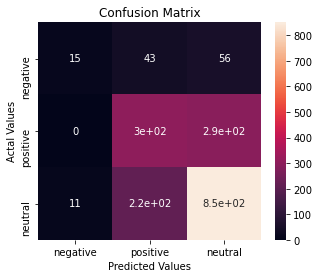

In [105]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [106]:
recall_score(y_val, prediction, average = 'weighted')

0.6538031319910514

In [107]:
print(metrics.classification_report(y_val, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.577     0.132     0.214       114
           1      0.539     0.508     0.523       596
           2      0.709     0.789     0.747      1078

    accuracy                          0.654      1788
   macro avg      0.608     0.476     0.495      1788
weighted avg      0.644     0.654     0.639      1788



### Tf-idf Vectorizer Multinomial Naive Bayes

In [108]:
X_train_vec, X_val_vec = prepare_transformed_datasets(TfidfVectorizer(), X_t, y_t, X_val, y_val)

In [109]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t, X_val_vec)

In [110]:
accuracy_score(y_val, prediction)

0.6459731543624161

In [111]:
cm = confusion_matrix(y_val, prediction)
cm

array([[   3,   11,  100],
       [   0,  131,  465],
       [   0,   57, 1021]])

In [112]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive','neutral'], 
                     columns = ['negative','positive','neutral'])

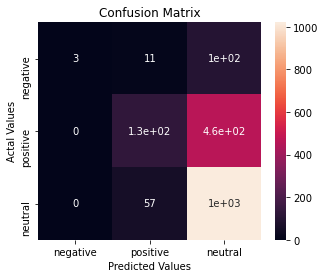

In [113]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [114]:
recall_score(y_val, prediction, average = 'weighted')

0.6459731543624161

In [115]:
print(metrics.classification_report(y_val, prediction, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.026     0.051       114
           1      0.658     0.220     0.330       596
           2      0.644     0.947     0.767      1078

    accuracy                          0.646      1788
   macro avg      0.767     0.398     0.382      1788
weighted avg      0.671     0.646     0.575      1788



### CountVectoriser & Tf-idf  MultiNB

In [116]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_t)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

model = MultinomialNB()
clf = model.fit(X_train_tfidf, y_t)


In [118]:
X_test_tf = count_vect.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

predicted = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_val, predicted))


Accuracy: 0.6459731543624161


In [125]:
cm = confusion_matrix(y_val, predicted)
cm

array([[   3,   11,  100],
       [   0,  131,  465],
       [   0,   57, 1021]])

In [120]:
print(metrics.classification_report(y_val, predicted))


              precision    recall  f1-score   support

           0       1.00      0.03      0.05       114
           1       0.66      0.22      0.33       596
           2       0.64      0.95      0.77      1078

    accuracy                           0.65      1788
   macro avg       0.77      0.40      0.38      1788
weighted avg       0.67      0.65      0.58      1788



### RandomForest - Count Vectoriser

In [126]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t, y_t, X_val, y_val)

In [127]:
prediction, model = train_predict_model(RandomForestClassifier(n_estimators=5000, max_features=500, max_depth=10), X_train_vec, y_t, X_val_vec)


In [128]:
accuracy_score(y_val, prediction)

0.639821029082774

In [129]:
cm = confusion_matrix(y_val, prediction)
cm

array([[   0,    4,  110],
       [   0,   87,  509],
       [   0,   21, 1057]])

In [130]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive','neutral'], 
                     columns = ['negative','positive','neutral'])

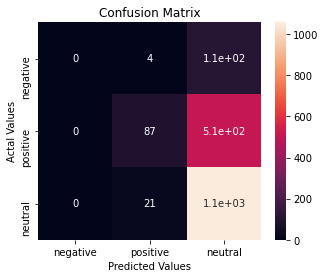

In [131]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [132]:
recall_score(y_val, prediction, average = 'weighted')

0.639821029082774

In [133]:
print(metrics.classification_report(y_val, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       114
           1      0.777     0.146     0.246       596
           2      0.631     0.981     0.768      1078

    accuracy                          0.640      1788
   macro avg      0.469     0.375     0.338      1788
weighted avg      0.639     0.640     0.545      1788



/Users/davidboyd/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Evaluation

After evaluating several different transformations and models, with a focus on optimising towards our recall score, we are getting varied results, this could be due to several reasons, however the main one to call out is the fact that the initial dataset is heavily imbalanced towards the neutral tweet compared to the negative sentiment tweets. As a result on all of the models trialled the negative sentiment category always had the lowest results. 

The best performing model on both occassions has been the `CountVectorizer Multinomial Naive Bayes` model

## Future steps & Limitations

In order to further refine the model in the future, the following limitations need to be addressed:

- Collect more data that allows the class imbalance between categories to be more balanced

Improvements could be made by switching approach from trialling out supervised ML models such as logisitic regression, RandomForest and Multinomial Naive Bayes. Instead it is worth testing out a CNN approach using more advanced techniques such as gensim, GloVe and Word2Vec to help us the hidden layer inside the neural networks to better make the connection between the context of the tweet and the overall sentiment